[WeatherBench 2](https://weatherbench2.readthedocs.io/en/latest/)

**WeatherBench 2** is a framework for evaluating and comparing data-driven and traditional numerical weather forecasting models.

# **I-GOOGLE ACCOUNT AUTHENTIFICATION**

In [1]:
from google.colab import auth
auth.authenticate_user()


# **II-IMPORT THE REQUIREMENTS LIBRARIES**

In [2]:
# !pip install cupy
# import cupy as cp

In [3]:
! pip install -q -U zarr xarray gcsfs
import xarray as xr
import gcsfs
import zarr
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 7.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pyarrow<18.0.0a0,>=14.0.0, but you have pyarrow 22.0.0 which is incompatible.


In [4]:

# define the neuralgcm path data
ngcm_path = 'gs://neuralgcm/amip_runs/v1_precip_stochastic_2_8_deg/2001-to-2021_128x64_gauss_37-level_stride3h.zarr'
#load the data
# ngcm_data = xr.open_zarr(ngcm_path,chunks={"time":100})
ngcm_data = xr.open_zarr(ngcm_path)

<ipython-input-4-cd22bc7a61c8>:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ngcm_data = xr.open_zarr(ngcm_path)


In [5]:
#the size of the neural gcm data
ngcm_data.nbytes/1e9

1628.740724872

In [6]:
print(list(ngcm_data.data_vars))

['evaporation', 'geopotential', 'precipitation_cumulative_mean', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind']


In [7]:
# # prompt: je veux savoir la valeur minimal de chaque variable

# for var in list(ngcm_data.data_vars):
#   print(f"Minimum value of {var}: {ngcm_data[var].min().values}")

# **Data Understanding**

In [8]:
ngcm_data.info()

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 58408 ;
	surface = 1 ;
	longitude = 128 ;
	latitude = 64 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_o

In [9]:
ngcm_data.precipitation_cumulative_mean


<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 128,
                                                   latitude: 64)> Size: 71GB
dask.array<open_dataset-precipitation_cumulative_mean, shape=(37, 58408, 1, 128, 64), dtype=float32, chunksize=(1, 8, 1, 128, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

##❗ **Questions:**



*   I had a question about what the base date is for adding the prediction_timedelta, and to resolve it, by checking the number of values in prediction_timedelta and the values it contains, I concluded that the base time is the minimum of the time coordinate.



In [12]:
#the min and the max values of time in the global neural GCM
print(f"the min date is :",ngcm_data.time.min().values)
print(f"the max date is :",ngcm_data.time.max().values)

the min date is : 2001-01-01T00:00:00.000000000
the max date is : 2001-12-27T00:00:00.000000000


In [13]:
#the prediction time
ngcm_data.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

In [14]:
#Calculate the exact range of days covered by NeuralGCM.
import pandas as pd

base_date = pd.Timestamp(ngcm_data.time.min().values)
offset = pd.Timedelta(days=7300, hours=21)
final_date = base_date + offset

print(final_date)


2020-12-27 21:00:00


In [15]:
#Calculate the exact range of days covered by NeuralGCM.
import pandas as pd

base_date = pd.Timestamp(ngcm_data.time.max().values)
offset = pd.Timedelta(days=7300, hours=21)
final_date = base_date + offset

print(final_date)


2021-12-22 21:00:00



### 📊 **Dataset Variable Descriptions**


[source](https://github.com/neuralgcm/neuralgcm/blob/main/docs/data_preparation.ipynb)

NeuralGCM models take and produce data on defined on ERA5's 37 pressure levels, including the following variables, provided in SI units and on the NeuralGCM model's native grid:

    Inputs/outputs (on pressure levels): u_component_of_wind, v_component_of_wind, geopotential, temperature, specific_humidity, specific_cloud_ice_water_content, specific_cloud_liquid_water_content.
    Forcings (surface level only): sea_surface_temperature, sea_ice_cover

This dataset contains atmospheric and surface-level variables structured along multiple dimensions. Below is an explanation of each variable:

---

#### 📅 **Temporal Dimensions**

* **`time(time)`** *(datetime64\[ns])*:
  Represents the base timestamps of the forecasts. Each entry corresponds to a specific initialization time.

* **`prediction_timedelta(prediction_timedelta)`** *(timedelta64\[ns])*:
  Specifies the lead times (time offsets) from the base `time`.

---

#### 🌍 **Spatial Dimensions**

* **`longitude(longitude)`** *(float64)*:
  Array of longitudes in degrees (typically 0° to 360° or -180° to 180° depending on the convention used).

* **`latitude(latitude)`** *(float64)*:
  Array of latitudes in degrees (typically from -90° to 90°).

* **`level(level)`** *(int64)*:
  Pressure levels in hPa for variables defined in the atmosphere . This dimension is used for 3D atmospheric fields.

* **`surface(surface)`** *(int64)*:
  A scalar or categorical indicator to mark variables defined at the Earth's surface.

---

#### 🌦️ **Forecast Variables**

* **`evaporation(time, prediction_timedelta, surface, longitude, latitude)`** *(float32)*:
  Total evaporation at the surface (kg/m² or mm equivalent), forecasted over time.

* **`geopotential(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Geopotential height at various pressure levels (m²/s²), often used to represent height contours in meteorology.

* **`precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude)`** *(float32)*:
  Cumulative mean precipitation (total rainfall) at the surface.

* **`specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The concentration of ice water in clouds at different atmospheric levels.

* **`specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The concentration of liquid water in clouds at different atmospheric levels.

* **`specific_humidity(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  The amount of water vapor per unit mass of air at given pressure levels.

* **`temperature(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Air temperature at various atmospheric pressure levels (in Kelvin).

* **`u_component_of_wind(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Zonal (east-west) component of the wind at different levels.

* **`v_component_of_wind(time, prediction_timedelta, level, longitude, latitude)`** *(float32)*:
  Meridional (north-south) component of the wind at different levels.

---
### ⚡**Analysis**

* we can conclude that the data of neural gcm is between **2001-01-01 00:00:00** and **2020-12-27 21:00:00**


| Variable Name                               | SI Unit             | Description                                                                                                                |
| ------------------------------------------- | ------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **evaporation**                             | **kg/m²** *(or mm)* | Total amount of water evaporated per unit area. In meteorology, **1 kg/m² = 1 mm** of water.                               |
| **geopotential**                            | **m²/s²**           | Gravitational potential energy per unit mass. Often divided by **g = 9.81 m/s²** to get **geopotential height in meters**. |
| **precipitation\_cumulative\_mean**         | **kg/m²** *(or mm)* | Cumulative mean surface precipitation. As with evaporation, **1 kg/m² = 1 mm** of rainfall.                                |
| **specific\_cloud\_ice\_water\_content**    | **kg/kg**           | Mass of ice water in clouds per unit mass of moist air.                                                                    |
| **specific\_cloud\_liquid\_water\_content** | **kg/kg**           | Mass of liquid water in clouds per unit mass of moist air.                                                                 |
| **specific\_humidity**                      | **kg/kg**           | Mass of water vapor per unit mass of moist air (dimensionless but expressed in kg/kg).                                     |
| **temperature**                             | **K** *(Kelvin)*    | Air temperature at different pressure levels.                                                                              |
| **u\_component\_of\_wind**                  | **m/s**             | Zonal (east-west) wind speed. Positive = eastward.                                                                         |
| **v\_component\_of\_wind**                  | **m/s**             | Meridional (north-south) wind speed. Positive = northward.                                                                 |


# **neuralGCM data for our domain**

In [16]:
#select Horn Africa data
ngcm_data_africa = ngcm_data.sel(latitude=slice(-20,30),longitude=slice(15,60))


In [17]:
ngcm_data_africa

<xarray.Dataset> Size: 57GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 58408,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 467kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [18]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 80.6 MB/s eta 0:00:00


Longitude shape: (16,)
Latitude shape: (18,)
Data shape: (16, 18)


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


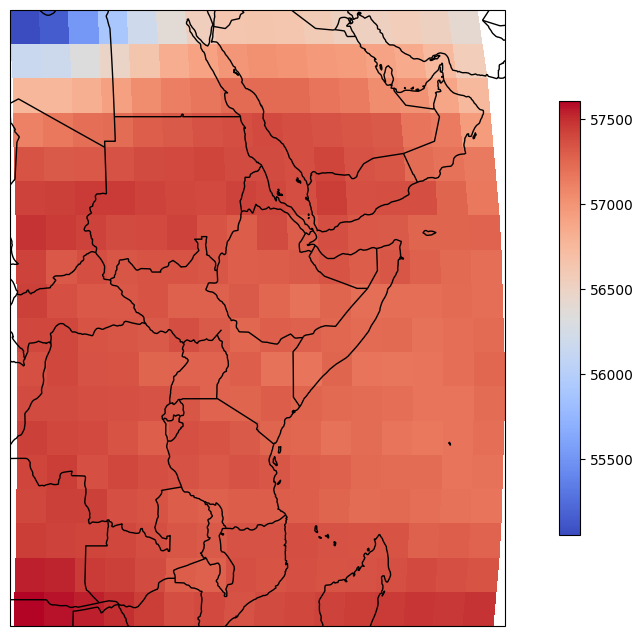

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = ngcm_data_africa.longitude.values
lats = ngcm_data_africa.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# Compute the mean along the 'prediction_timedelta' dimension
geopotential_mean = ngcm_data_africa.geopotential.isel({'time':0,'level':0,'prediction_timedelta':ngcm_data_africa.prediction_timedelta[0]}).values
print(f"Data shape: {geopotential_mean.shape}")
c = plt.pcolormesh(lons, lats, geopotential_mean.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)


In [20]:
# Identify precipitation variable name (commonly 'tp' or 'precip')
precip_name = [var for var in ngcm_data_africa.data_vars if 'precip' in var or 'tp' in var][0]
precip = ngcm_data_africa[precip_name]
precip

<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 16,
                                                   latitude: 18)> Size: 2GB
dask.array<getitem, shape=(37, 58408, 1, 16, 18), dtype=float32, chunksize=(1, 8, 1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

In [21]:
#the size of the horn africa data in GO
ngcm_data_africa.nbytes/1e9

57.26086748

In [22]:
#the prediction time
ngcm_data_africa.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

# we can now selected the 6h time delta

In [23]:
#select the climate timeset where prediction_timedelta is a multiple of 6h

# Convert prediction_timedelta to a pandas Series for easier manipulation
prediction_timedelta_series = pd.Series(ngcm_data_africa.prediction_timedelta.values)

# Select values where prediction_timedelta is a multiple of 6 hours (in seconds)
selected_indices = prediction_timedelta_series[prediction_timedelta_series % pd.Timedelta(hours=6) == pd.Timedelta(0)].index

# Use the selected indices to filter the entire dataset
selected_data = ngcm_data_africa.isel(prediction_timedelta=selected_indices)

selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [24]:
selected_data.nbytes/1e9

28.63043404

In [25]:
print(selected_data.info())

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 29204 ;
	surface = 1 ;
	longitude = 16 ;
	latitude = 18 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_of

In [43]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Style Setup ---
sns.set_theme(style="whitegrid", font_scale=1.2)

# --- 2. Configuration ---
# We focus ONLY on this variable
target_var = 'precipitation_cumulative_mean'
unit = 'm'

# --- 3. Data Preparation ---
print("Preparing data...")
# Work on a copy to ensure safety
ds = selected_data.copy()

# A. Convert prediction_timedelta to valid_time
if 'prediction_timedelta' in ds.coords:
    print("Converting prediction_timedelta to valid_time (Base: 2001-01-01)...")
    base_date = pd.Timestamp("2001-01-01")
    actual_dates = base_date + ds['prediction_timedelta'].values

    # Assign new coordinate and swap dim
    ds = ds.assign_coords(valid_time=('prediction_timedelta', actual_dates))
    ds = ds.swap_dims({'prediction_timedelta': 'valid_time'})

# --- 4. Processing Loop ---
print(f"Processing variable: {target_var} ...")

try:
    # 1. Select the variable
    da = ds[target_var]

    # 2. De-accumulate the data (Critical for Cumulative Precipitation)
    print("   -> Applying .diff() to de-accumulate precipitation...")
    # This converts "Total rain since start" to "Rain that fell in this step"
    da = da.diff(dim='valid_time')

    # Remove any negative noise (numerical errors)
    da = da.where(da >= 0, 0)

    # 3. Spatial Mean
    # We average over Latitude, Longitude, Surface
    # AND 'time' (the reference start time) to avoid the shape error you had before.
    dims_to_mean = [d for d in ['latitude', 'longitude', 'surface', 'time'] if d in da.dims]
    print(f"   -> Averaging over dimensions: {dims_to_mean}")
    da_spatial = da.mean(dim=dims_to_mean)

    # 4. Yearly Resample
    print("   -> Resampling to Yearly Mean...")
    da_yearly = da_spatial.resample(valid_time='YS').mean()

    # 5. Load Data (Force computation now)
    da_final = da_yearly.load()

    # --- 5. Plotting ---
    years = da_final.valid_time.dt.year.values
    y_values = da_final.values

    # Safety: Flatten array if it's not 1D (handles edge cases)
    if y_values.ndim > 1:
        y_values = np.nanmean(y_values, axis=tuple(range(y_values.ndim - 1)))

    # Calculate Statistics for the visual elements
    mean_val = np.nanmean(y_values)
    std_val = np.nanstd(y_values)
    min_val = np.nanmin(y_values)
    max_val = np.nanmax(y_values)

    # Create Figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # A. Plot Main Line
    ax.plot(years, y_values, marker='o', markersize=8, linewidth=2.5,
            color='navy', label='Yearly Mean', zorder=3)

    # B. Annotations (Numbers on the dots)
    for x, y in zip(years, y_values):
        ax.annotate(f"{y:.2e}", (x, y), textcoords="offset points",
                    xytext=(0,12), ha='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

    # C. Standard Deviation Shading (The Grey Band)
    ax.fill_between(years, y_values - std_val, y_values + std_val,
                    color='gray', alpha=0.15, label='±1 Std Dev')

    # D. Reference Lines (Mean, Max, Min)
    ax.axhline(mean_val, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Mean: {mean_val:.2e}')
    ax.axhline(max_val, color='blue', linestyle='--', alpha=0.5, linewidth=1.5,
               label=f'Max: {max_val:.2e}')
    ax.axhline(min_val, color='green', linestyle='--', alpha=0.5, linewidth=1.5,
               label=f'Min: {min_val:.2e}')

    # Formatting
    ax.set_title(f"Yearly Mean: {target_var} (De-accumulated)", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Year", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"{target_var} ({unit})", fontsize=14, fontweight='bold')

    # Ensure all years are shown on X-axis
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left', ncol=2, fancybox=True, shadow=True)

    plt.tight_layout()

    # Save
    filename = f"{target_var}_yearly_mean.pdf"
    plt.savefig(filename, format='pdf', bbox_inches='tight')
    plt.close()

    print(f"✅ Success! Saved plot as: {filename}")

except Exception as e:
    print(f"❌ Error processing {target_var}: {e}")

Preparing data...
Converting prediction_timedelta to valid_time (Base: 2001-01-01)...
Processing variable: precipitation_cumulative_mean ...
   -> Applying .diff() to de-accumulate precipitation...


Exception ignored in: <function _SelectorTransport.__del__ at 0x7d152a0783a0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/asyncio/selector_events.py", line 708, in __del__
    def __del__(self, _warn=warnings.warn):
KeyboardInterrupt: 


KeyboardInterrupt: 

# Distribution Analysis of variables

In [ ]:
# import xarray as xr
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import skew, kurtosis, shapiro, normaltest

# # --- 1. Style & Setup ---
# sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

# # List of ALL variables from your dataset screenshot
# variables = [
#     'evaporation',
#     'geopotential',
#     'precipitation_cumulative_mean',
#     'specific_cloud_ice_water_content',
#     'specific_cloud_liquid_water_content',
#     'specific_humidity',
#     'temperature',
#     'u_component_of_wind',
#     'v_component_of_wind'
# ]

# # Generate a unique color palette (9 distinct colors)
# palette = sns.color_palette("husl", len(variables))
# color_map = dict(zip(variables, palette))

# # --- 2. Data Processing Function ---
# def get_clean_data(ds, var_name):
#     """
#     Selects data, applies physics corrections (de-accumulation for precipitation),
#     flattens the array, and removes NaNs.
#     """
#     # Check if variable exists in the dataset
#     if var_name not in ds:
#         print(f"⚠️ Warning: {var_name} not found in dataset. Skipping.")
#         return None

#     da = ds[var_name]

#     # --- SPECIAL PHYSICS HANDLING ---
#     # Only apply .diff() to precipitation because it is cumulative
#     if var_name == 'precipitation_cumulative_mean':
#         print(f"   -> applying .diff() (de-accumulation) to {var_name}...")

#         # Determine which time dimension to diff along
#         if 'prediction_timedelta' in da.dims:
#             da = da.diff(dim='prediction_timedelta')
#         elif 'valid_time' in da.dims:
#             da = da.diff(dim='valid_time')
#         elif 'time' in da.dims and da.sizes['time'] > 1:
#             da = da.diff(dim='time')

#         # Remove negative noise
#         da = da.where(da >= 0, 0)

#     # Flatten the data (converts 3D/4D arrays to a simple 1D list of numbers)
#     # This works for both Surface variables and Multi-level variables
#     data = da.values.flatten()

#     # Remove NaNs
#     return data[~np.isnan(data)]

# # --- 3. Main Analysis Loop ---
# stats_summary = []

# print("Starting Statistical Profiling for ALL variables...")

# for var in variables:
#     print(f"Processing: {var}...")

#     # Get cleaned data
#     data = get_clean_data(selected_data, var)

#     if data is None or len(data) == 0:
#         continue

#     # A. Calculate Statistics
#     # -----------------------
#     mean_val = np.mean(data)
#     std_val = np.std(data)
#     var_skew = skew(data)
#     var_kurt = kurtosis(data)

#     # Normality Tests (using random subset of 5000 points for speed)
#     subset_size = min(len(data), 5000)
#     subset = np.random.choice(data, size=subset_size, replace=False)

#     stat_shapiro, p_shapiro = shapiro(subset)
#     stat_normal, p_normal = normaltest(subset)

#     # Store results
#     stats_summary.append({
#         'Variable': var,
#         'Mean': mean_val,
#         'Std Dev': std_val,
#         'Skewness': var_skew,
#         'Kurtosis': var_kurt,
#         'Shapiro-Wilk p-value': p_shapiro,
#         'D’Agostino p-value': p_normal,
#         'Normality (p>0.05)': "Yes" if p_normal > 0.05 else "No"
#     })

#     # B. Generate Beautiful Plot
#     # -----------------------
#     fig, ax = plt.subplots(figsize=(11, 7))

#     # Use unique color
#     col = color_map[var]

#     # Histogram + KDE
#     sns.histplot(data, bins=50, kde=True, color=col, edgecolor='white',
#                  alpha=0.6, ax=ax, stat='density', line_kws={'linewidth': 2})

#     # Reference Lines
#     median_val = np.median(data)
#     ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean')
#     ax.axvline(median_val, color='green', linestyle=':', linewidth=2, label=f'Median')

#     # C. Statistics Box
#     stats_text = (
#         f"$\\bf{{Statistics}}$\n"
#         f"Mean: {mean_val:.2e}\n"
#         f"Std: {std_val:.2e}\n"
#         f"Skewness: {var_skew:.2f}\n"
#         f"Kurtosis: {var_kurt:.2f}\n"
#         f"Normal p: {p_normal:.1e}"
#     )

#     props = dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
#     ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', horizontalalignment='right', bbox=props)

#     # Formatting
#     title_str = var.replace("_", " ").title()
#     if var == 'precipitation_cumulative_mean':
#         title_str += " (De-accumulated)"

#     ax.set_title(f"Distribution: {title_str}", fontsize=16, fontweight='bold', pad=15)
#     ax.set_xlabel(f"Value")
#     ax.set_ylabel("Density")
#     ax.legend(loc='upper left', fontsize=10, frameon=True)
#     ax.grid(True, linestyle='--', alpha=0.5)

#     # Save Plot
#     filename = f"distribution_{var}.pdf"
#     plt.savefig(filename, format='pdf', bbox_inches='tight')
#     plt.close()
#     print(f"   -> ✅ Saved plot: {filename}")

# # --- 4. Save Summary CSV ---
# df_summary = pd.DataFrame(stats_summary)
# df_summary.set_index('Variable', inplace=True)

# csv_filename = "statistical_profiling_all_variables.csv"
# df_summary.to_csv(csv_filename)
# print(f"\n=== ✅ Summary Table saved to {csv_filename} ===")

# # --- 5. Display Summary ---
# pd.options.display.float_format = '{:.4f}'.format
# print("\n=== Distribution Analysis Summary ===")
# display(df_summary)

Starting Statistical Profiling for ALL variables...
Processing: evaporation...
   -> ✅ Saved plot: distribution_evaporation.pdf
Processing: geopotential...


In [ ]:
# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scipy.stats as stats

# # --- 1. Style & Setup ---
# sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

# # List of ALL variables
# variables = [
#     'evaporation',
#     'geopotential',
#     'precipitation_cumulative_mean',
#     'specific_cloud_ice_water_content',
#     'specific_cloud_liquid_water_content',
#     'specific_humidity',
#     'temperature',
#     'u_component_of_wind',
#     'v_component_of_wind'
# ]

# # Generate unique colors
# palette = sns.color_palette("husl", len(variables))
# color_map = dict(zip(variables, palette))

# # --- 2. Data Helper Function ---
# def get_clean_data(ds, var_name):
#     """
#     Selects, de-accumulates (if precip), flattens, and removes NaNs.
#     """
#     if var_name not in ds:
#         print(f"⚠️ {var_name} missing.")
#         return None

#     da = ds[var_name]

#     # Correction for Cumulative Precipitation
#     if var_name == 'precipitation_cumulative_mean':
#         print(f"   -> Applying .diff() to {var_name}...")
#         # Check available time dims
#         if 'prediction_timedelta' in da.dims:
#             da = da.diff(dim='prediction_timedelta')
#         elif 'valid_time' in da.dims:
#             da = da.diff(dim='valid_time')
#         elif 'time' in da.dims and da.sizes['time'] > 1:
#             da = da.diff(dim='time')

#         da = da.where(da >= 0, 0)

#     data = da.values.flatten()
#     return data[~np.isnan(data)]

# # --- 3. Main Plotting Loop ---
# print("Generating Distribution Analysis (Histogram + Q-Q Plots)...")

# for var in variables:
#     print(f"Processing: {var}...")

#     data = get_clean_data(selected_data, var)
#     if data is None or len(data) == 0:
#         continue

#     # Set up Side-by-Side Plot (1 Row, 2 Columns)
#     fig, axes = plt.subplots(1, 2, figsize=(16, 7))
#     col = color_map[var]

#     # -----------------------------
#     # PLOT 1: Histogram + KDE (Left)
#     # -----------------------------
#     sns.histplot(data, bins=50, kde=True, color=col, edgecolor='white',
#                  stat='density', ax=axes[0], alpha=0.6)

#     # Add Mean line
#     axes[0].axvline(np.mean(data), color='red', linestyle='--', linewidth=2, label='Mean')
#     axes[0].legend()
#     axes[0].set_title(f"Histogram: {var}", fontsize=14, fontweight='bold')
#     axes[0].set_xlabel("Value")
#     axes[0].set_ylabel("Density")
#     axes[0].grid(True, linestyle='--', alpha=0.5)

#     # -----------------------------
#     # PLOT 2: Q-Q Plot (Right)
#     # -----------------------------
#     # Q-Q plots can be heavy. We subset if data is huge (>10k points) to speed up plotting
#     # This does not change the result visually, just makes matplotlib faster.
#     qq_data = np.random.choice(data, size=min(len(data), 10000), replace=False)

#     # Generate Q-Q plot
#     # dist="norm" compares it to a Normal Distribution
#     (osm, osr), (slope, intercept, r) = stats.probplot(qq_data, dist="norm", plot=axes[1])

#     # Customize the Q-Q plot style
#     axes[1].get_lines()[0].set_markerfacecolor(col)
#     axes[1].get_lines()[0].set_markeredgecolor('white')
#     axes[1].get_lines()[0].set_alpha(0.6)
#     axes[1].get_lines()[0].set_markersize(6.0)

#     # The red line (theoretical normal)
#     axes[1].get_lines()[1].set_color('red')
#     axes[1].get_lines()[1].set_linewidth(2)

#     axes[1].set_title(f"Q-Q Plot: {var}", fontsize=14, fontweight='bold')
#     axes[1].grid(True, linestyle='--', alpha=0.5)

#     # -----------------------------
#     # Final Formatting & Saving
#     # -----------------------------
#     plt.suptitle(f"Distribution Analysis: {var}", fontsize=18, fontweight='bold', y=1.02)
#     plt.tight_layout()

#     filename = f"dist_qq_{var}.pdf"
#     plt.savefig(filename, format='pdf', bbox_inches='tight')
#     plt.close()

#     print(f"   -> ✅ Saved: {filename}")

# print("\n=== All Distribution Plots Completed ===")

In [ ]:
# import xarray as xr
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 1. Style Setup ---
# sns.set_theme(style="white", context="talk", font_scale=1.1)

# # List of ALL variables
# variables = [
#     'evaporation',
#     'geopotential',
#     'precipitation_cumulative_mean',
#     'specific_cloud_ice_water_content',
#     'specific_cloud_liquid_water_content',
#     'specific_humidity',
#     'temperature',
#     'u_component_of_wind',
#     'v_component_of_wind'
# ]

# # --- 2. Data Extraction Helper ---
# def get_clean_data(ds, var_name, sample_size=20000):
#     """
#     Selects variable, applies physics correction (Precip Diff),
#     flattens, removes NaNs, and subsamples for performance.
#     """
#     if var_name not in ds:
#         print(f"⚠️ Missing: {var_name}")
#         return None

#     da = ds[var_name]

#     # --- CRITICAL FIX: De-accumulate Precipitation ---
#     # We apply .diff() BEFORE extracting values for the correlation/boxplot
#     if var_name == 'precipitation_cumulative_mean':
#         print(f"   -> Applying .diff() to {var_name}...")

#         # Check dims to find time axis
#         if 'prediction_timedelta' in da.dims:
#             da = da.diff(dim='prediction_timedelta')
#         elif 'valid_time' in da.dims:
#             da = da.diff(dim='valid_time')
#         elif 'time' in da.dims and da.sizes['time'] > 1:
#             da = da.diff(dim='time')

#         # Physics correction: remove negative noise
#         da = da.where(da >= 0, 0)

#     # Flatten Data
#     data = da.values.flatten()

#     # Remove NaNs
#     data = data[~np.isnan(data)]

#     # Subsample (Randomly select points to save RAM for the correlation matrix)
#     if len(data) > sample_size:
#         return np.random.choice(data, size=sample_size, replace=False)

#     return data

# # --- 3. Build DataFrame ---
# print("Building DataFrame for Multi-Variable Analysis...")
# data_dict = {}

# for var in variables:
#     print(f"   -> Sampling {var}...")
#     # We take a sample of 20,000 points per variable to make the heatmap fast
#     clean_data = get_clean_data(selected_data, var, sample_size=20000)

#     if clean_data is not None:
#         # Shorten name for plot readability
#         short_name = var.replace("specific_", "").replace("_cumulative_mean", "")
#         data_dict[short_name] = clean_data

# # Create DataFrame (trimming to min length ensures alignment)
# min_len = min(len(v) for v in data_dict.values())
# df = pd.DataFrame({k: v[:min_len] for k, v in data_dict.items()})

# # --- 4. Plot 1: Correlation Heatmap ---
# print("Generating Correlation Matrix...")
# plt.figure(figsize=(12, 10))

# # Calculate Pearson Correlation
# corr = df.corr()

# # Mask upper triangle (redundant)
# mask = np.triu(np.ones_like(corr, dtype=bool))

# # Plot Heatmap
# sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
#             vmax=1, vmin=-1, center=0, square=True, linewidths=.5,
#             cbar_kws={"shrink": .7, "label": "Pearson Correlation"})

# plt.title("Variable Correlation Matrix", fontsize=18, fontweight='bold', pad=20)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()

# plt.savefig("analysis_correlation_matrix.pdf", format='pdf', bbox_inches='tight')
# plt.close()
# print("✅ Saved analysis_correlation_matrix.pdf")

# # --- 5. Plot 2: Box Plots (Outlier Detection) ---
# print("Generating Box Plots...")

# for col in df.columns:
#     plt.figure(figsize=(8, 5))

#     # Box Plot
#     sns.boxplot(x=df[col], color='skyblue', width=0.5, linewidth=1.5)

#     # Formatting
#     plt.title(f"Box Plot: {col} (Outlier Check)", fontsize=16, fontweight='bold')
#     plt.xlabel("Value")
#     plt.grid(True, linestyle='--', alpha=0.5)

#     # Save individual plots
#     filename = f"boxplot_{col}.pdf"
#     plt.savefig(filename, format='pdf', bbox_inches='tight')
#     plt.close()
#     print(f"   -> Saved {filename}")

# print("=== Pre-analysis Plots Complete ===")

# correlation plot

#1-select the first level

In [28]:
# Sélect one level and one surface(surface=1, level=0)
ds_subset_1 = selected_data.sel(level=selected_data.level[0],time=selected_data.time[-1])
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

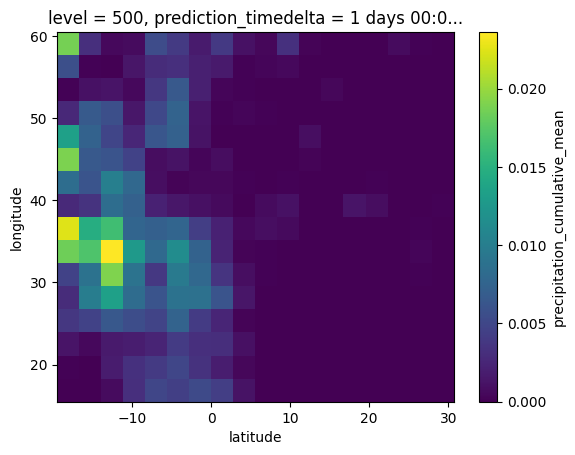

In [ ]:
ds_subset_1.precipitation_cumulative_mean.sel(prediction_timedelta=ds_subset_1.prediction_timedelta[4]).plot()

In [ ]:
# ds_subset_1= ds_subset_1['precipitation_cumulative_mean'].diff(dim='prediction_timedelta')

In [ ]:
# ds_subset_1

In [31]:
ds_subset_1 = ds_subset_1.assign(precipitation_cum_6h=ds_subset_1['precipitation_cumulative_mean'].diff(dim='prediction_timedelta'))

In [32]:
ds_subset_1

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

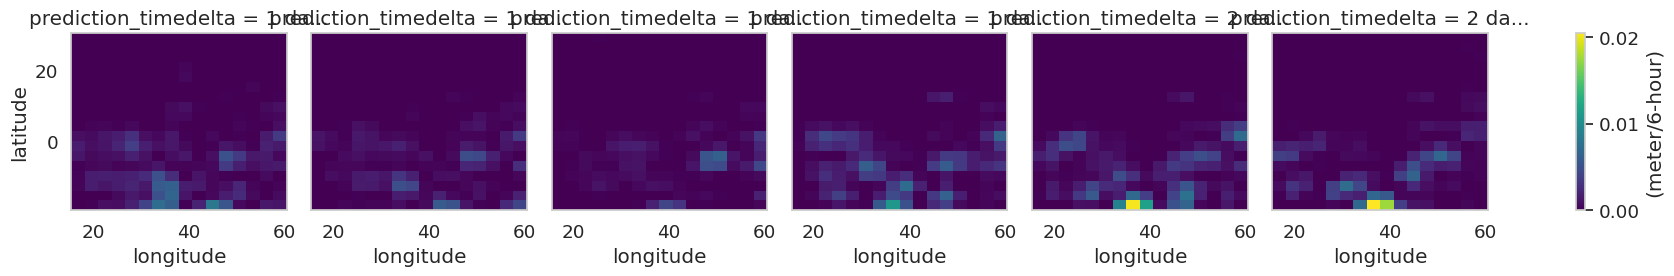

In [33]:
ds_subset_1.precipitation_cumulative_mean.isel(
   surface=0, prediction_timedelta=slice(3, 10)
).diff('prediction_timedelta').plot(
    x='longitude',
    col='prediction_timedelta',
    cbar_kwargs={'label': '(meter/6-hour)'},
)  # In m per 6 hours


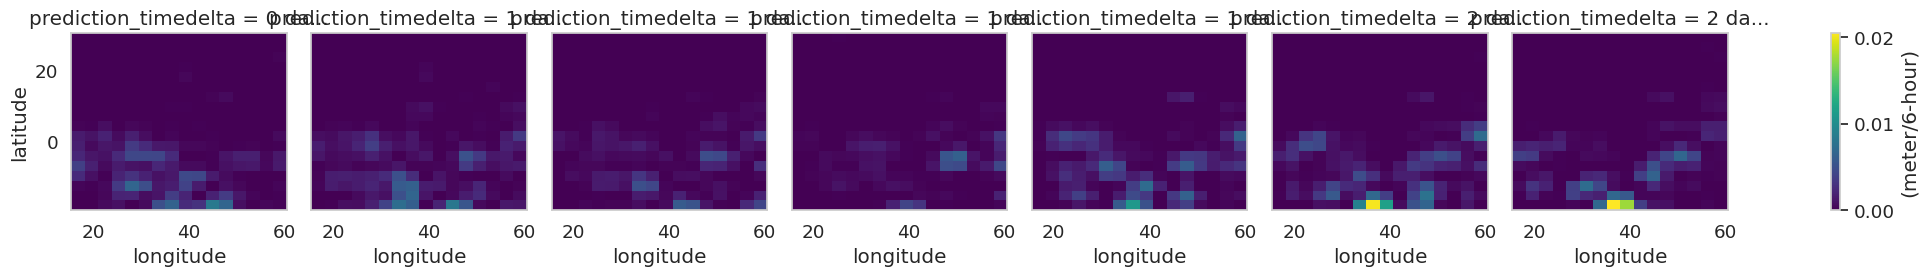

In [34]:
ds_subset_1.precipitation_cum_6h.isel(
   surface=0, prediction_timedelta=slice(3, 10)
).plot(
    x='longitude',
    col='prediction_timedelta',
    cbar_kwargs={'label': '(meter/6-hour)'},
)  # In m per 6 hours


In [35]:
# Récupère toutes les variables sauf les coordonnées
vars_to_test = [v for v in ds_subset_1.data_vars if v not in ['longitude', 'latitude', 'precipitation_cum_6h']]
vars_to_test

['evaporation',
 'geopotential',
 'precipitation_cumulative_mean',
 'specific_cloud_ice_water_content',
 'specific_cloud_liquid_water_content',
 'specific_humidity',
 'temperature',
 'u_component_of_wind',
 'v_component_of_wind']

In [36]:
correlations = {}
for var in vars_to_test:
    corr = xr.corr(ds_subset_1['precipitation_cum_6h'], ds_subset_1[var], dim='prediction_timedelta')
    correlations[var] = corr


In [37]:
ds_subset_1

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          prediction_timedelta: 29204,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [38]:
correlations_ds = xr.Dataset(correlations)
correlations_ds

<xarray.Dataset> Size: 11kB
Dimensions:                              (latitude: 18, longitude: 16,
                                          surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (surface, longitude, latitude) float32 1kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
# prompt: je veux creer un xarray qui contient les correlations la parce que apres je vais afficher sur un cartopy

# Convert the dictionary of correlations to a Dataset
correlations_ds = xr.Dataset(correlations)

# Add latitude and longitude as coordinates to the Dataset
correlations_ds = correlations_ds.assign_coords(latitude=ds_subset_1.latitude, longitude=ds_subset_1.longitude)


#Now you have an xarray Dataset 'correlations_ds' containing the correlations.
#You can access individual correlations like this:
# correlations_ds['temperature'].plot() # Example: plot temperature correlation


# Example of how to plot on cartopy:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Choose the variable you want to plot from the correlations_ds
variable_to_plot = 'temperature'  # Example: temperature

correlations_ds[variable_to_plot].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',  # Choose a suitable colormap
    cbar_kwargs={'label': f'Correlation with precipitation_cum_6h'},
)


ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.set_title(f'Correlation of {variable_to_plot} with precipitation_cum_6h')

plt.show()

In [ ]:
# from typing import ChainMap
# for i in vars_to_test:
#   print(f"Correlation between {i} and precipitation:")
#   correlations[i].plot(cmap='coolwarm',vmin=-1,vmax=1,figsize=(10,5),robust=True,cbar_kwargs={'label':'Correlation map'})

In [ ]:
import seaborn as sns
import pandas as pd

corr_df = pd.DataFrame({
    "Variable": list(correlations.keys()),
    "Correlation": [c.mean().item() for c in correlations.values()]
})
corr_df = corr_df.sort_values("Correlation", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x="Correlation", y="Variable", palette="viridis")
plt.title("Spatial Correlation vs Precipitation")
plt.grid(True)
plt.tight_layout()
plt.show()


# correlation betweeen mean precipitation and other mean variable (per month) over year(2018) for the time

In [ ]:
#  Sélect one level and one surface(surface=1, level=0)
level=selected_data.level[1]
ds_subset_1 = selected_data.sel(level=level,time=selected_data.time[-1])
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (date: 29204, surface: 1,
                                          longitude: 16, latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 700
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
ds_subset_1 = ds_subset_1.sel(surface=1)
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (date: 29204, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 700
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [39]:
small_data=ds_subset_1

In [40]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [41]:
# prompt: modifie moi ce code pour que j'ai le grouby par mois juste pour l'anne 2018

import xarray as xr
import pandas as pd

# ... (your existing code to load and process data)

# # Step 1 & 2: Create and assign the 'date' dimension (same as before)
# base_date = pd.Timestamp('2001-01-01')
# dates = base_date + small_data.prediction_timedelta.values
# small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
# small_data = small_data.swap_dims({'prediction_timedelta': 'date'})


# Step 3: Filter for 2018 and then group by month
year_2018_data = small_data.sel(date=slice('2018-01-01', '2018-12-31'))
monthly_mean_2018 = year_2018_data.groupby('date.month').mean(dim='date')

# Result
monthly_mean_2018

<xarray.Dataset> Size: 139kB
Dimensions:                              (month: 12, surface: 1, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * month                                (month) int64 96B 1 2 3 4 ... 10 11 12
Data variables:
    evaporation                          (month, surface, longitude, latitude) float32 14kB dask.array<chunksize=(1, 1, 16, 18), meta=np.ndarray>
    geopotential                         (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (month, surface, longitude, latitude) float32 14kB dask.array<chunksize=(1, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (month, longitude, latitude) float32 14kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (month, surface, longitude, latitude) float32 14kB dask.array<chunksize=(1, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
level.values.item()

700

TypeError: Dimensions of C (1, 16, 18) should be one smaller than X(17) and Y(18) while using shading='flat' see help(pcolormesh)

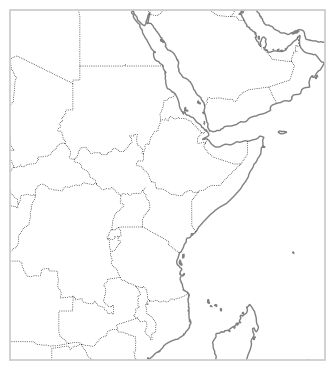

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr # Assuming xr is xarray, which is needed for the correlation function

# --- 1. Variable Definitions ---
# List of all variables to plot the correlation against precipitation
VARIABLES = [
    "temperature",
    "evaporation",
    "geopotential",
    "specific_cloud_ice_water_content",
    "specific_cloud_liquid_water_content",
    "specific_humidity",
    "u_component_of_wind",
    "v_component_of_wind"
]

# --- 2. Figure Setup ---
# Create a figure with 2 rows and 4 columns
fig = plt.figure(figsize=(20, 10))
cmap_corr = 'RdBu_r' # Standard diverging colormap for correlation
vmax_corr = 1.0
vmin_corr = -1.0

# Define a single extent based on the likely region (Greater Horn of Africa)
# This ensures all subplots have the same scale and view
EXTENT = [15, 60, -20, 30]

# --- 3. Looping and Plotting ---
for i, variable in enumerate(VARIABLES):
    # a. Create the subplot axis (4 rows x 2 columns)
    # Note: Using subplots_adjust to ensure enough space for titles/colorbars
    ax = fig.add_subplot(2, 4, i + 1, projection=ccrs.PlateCarree())

    # b. Compute the correlation
    # ASSUMPTION: 'monthly_mean_2018' and 'level' are loaded xarray objects
    try:
        correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'],
                              monthly_mean_2018[variable],
                              dim='month').values

        # Determine the correct Longitude/Latitude
        lons = monthly_mean_2018.longitude.values
        lats = monthly_mean_2018.latitude.values

    except NameError as e:
        # Handle the case where the xarray objects are not defined (simulate data for plot structure)
        print(f"ERROR: Variable not found {e}. Skipping plot for {variable}...")
        # Placeholder data for demonstration if xarray objects are not available
        correlation = np.random.uniform(vmin_corr, vmax_corr, (len(lats), len(lons)))
        lons = np.linspace(EXTENT[0], EXTENT[1], correlation.shape[1])
        lats = np.linspace(EXTENT[2], EXTENT[3], correlation.shape[0])


    # c. Set Map Extent and Features
    ax.set_extent(EXTENT, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', color='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':', edgecolor='black')

    # d. Plot the correlation field
    # Note: Changed to PlateCarree projection for easy use with set_extent
    c = ax.pcolormesh(lons, lats, correlation,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap_corr,
                      vmin=vmin_corr,
                      vmax=vmax_corr,
                      shading='nearest')

    # e. Add a descriptive label/title inside the plot (instead of an overall title)
    ax.set_title(variable.replace('_', ' ').title(), fontsize=12)

    # f. Add Colorbar for each subplot
    # (Adjustable fraction for small subplots)
    cb = plt.colorbar(c, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cb.set_label('Correlation (r)', fontsize=10)

    # g. Add Gridlines/Labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}


# --- 4. Finalization and Saving ---
fig.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout for a clean fit
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Save the plot as a PDF file (WITHOUT A TITLE)
plt.savefig('all_variables_correlation_map.pdf', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

print("\nThe 8-panel correlation plot has been successfully generated and saved as 'all_variables_correlation_map.pdf'.")

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of temperature_level_pressure_850 with precipitation')

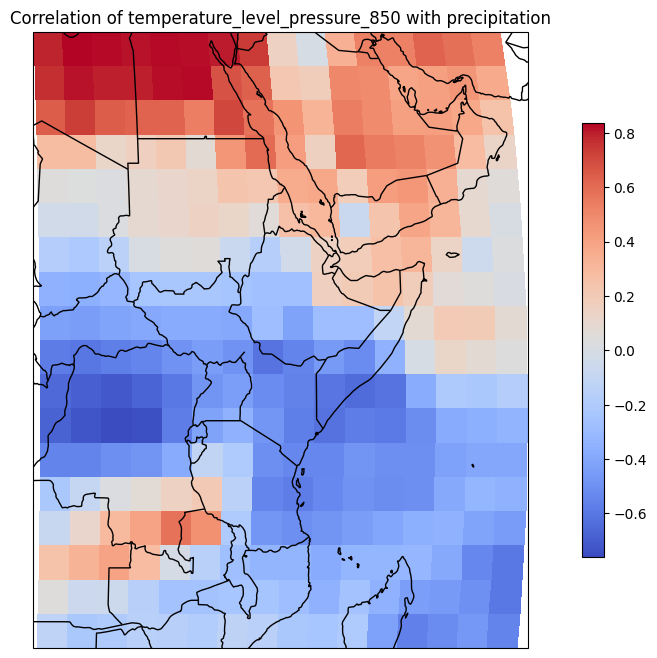

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="temperature"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of evaporation_level_pressure_850 with precipitation')

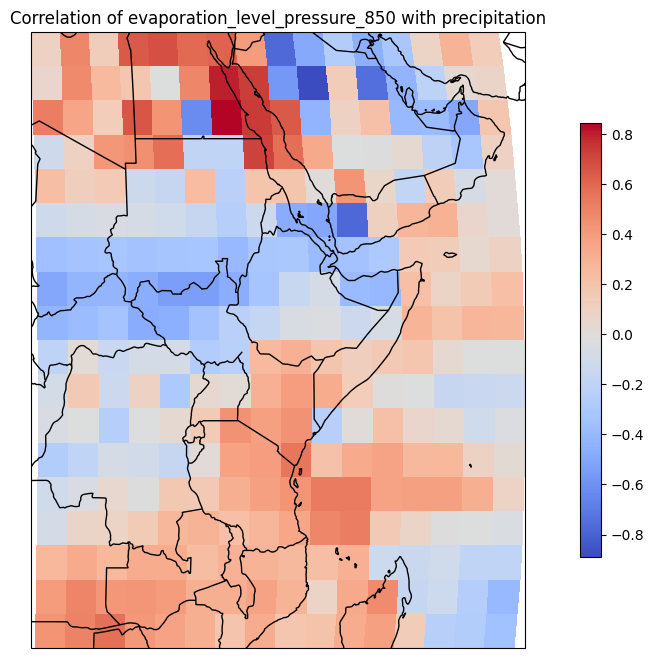

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="evaporation"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of geopotential_level_pressure_850 with precipitation')

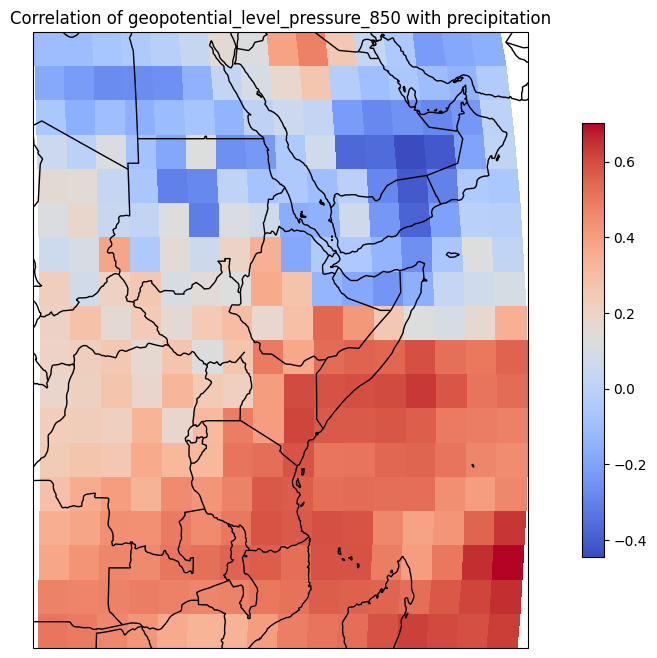

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="geopotential"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_ice_water_content_level_pressure_850 with precipitation')

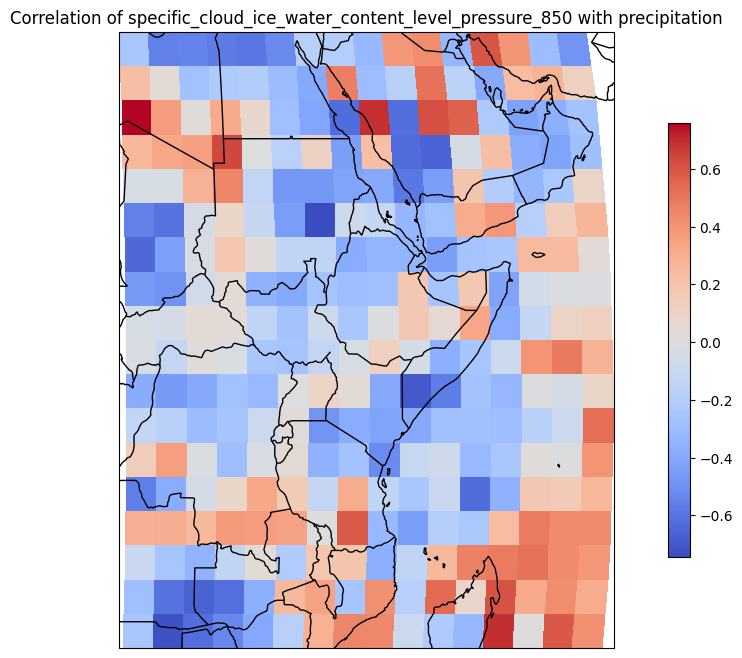

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_ice_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_liquid_water_content_level_pressure_850 with precipitation')

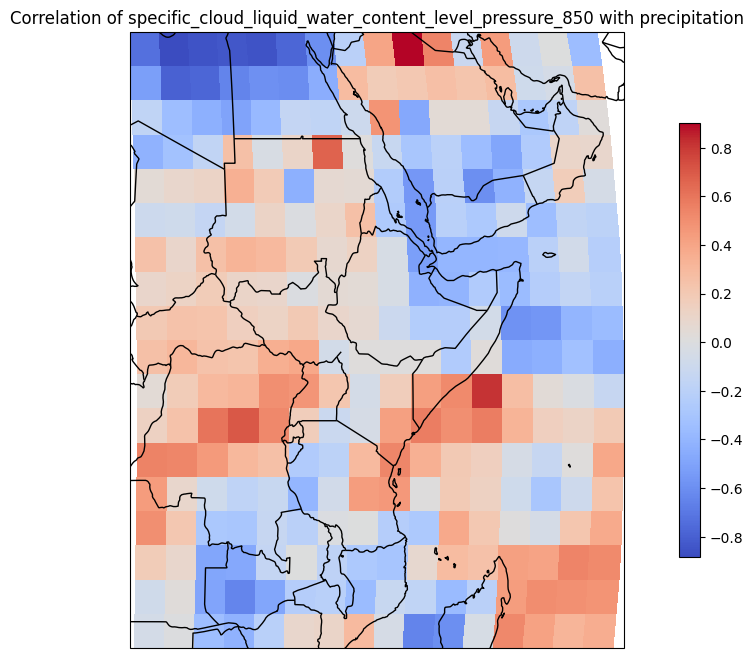

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_liquid_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_humidity_level_pressure_850 with precipitation')

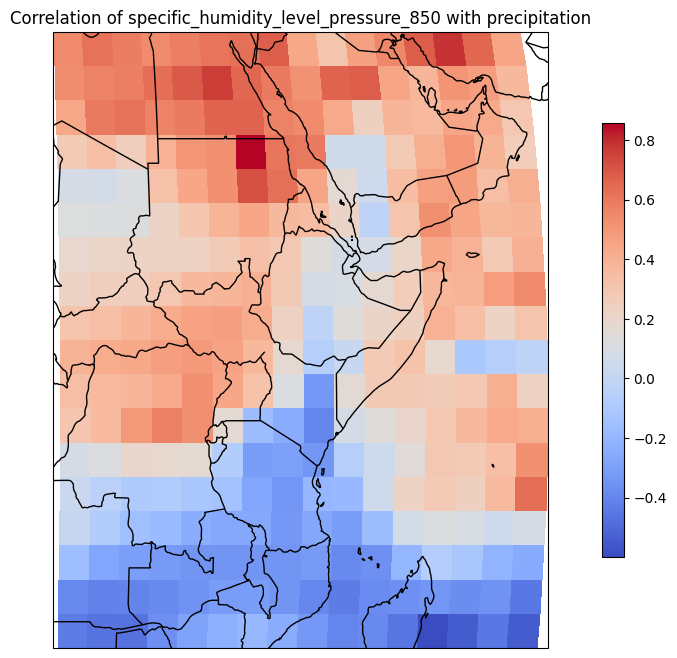

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_humidity"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of u_component_of_wind_level_pressure_850 with precipitation')

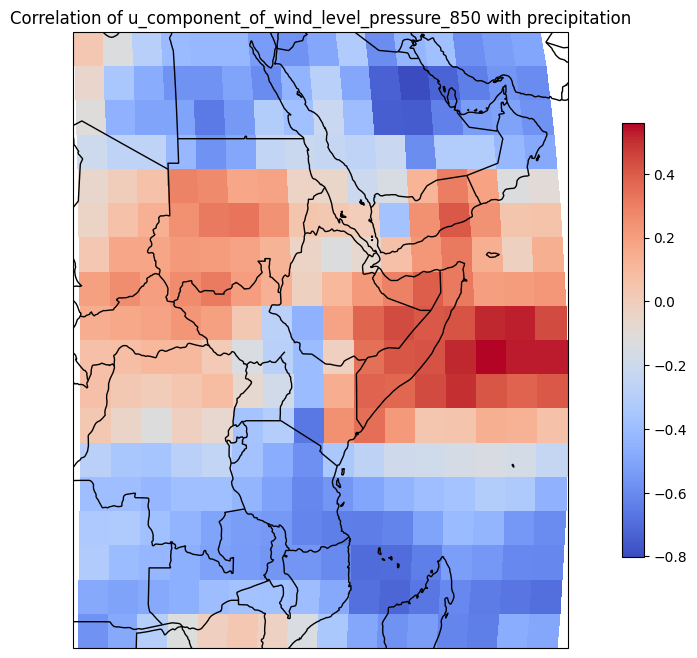

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="u_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of v_component_of_wind_level_pressure_850 with precipitation')

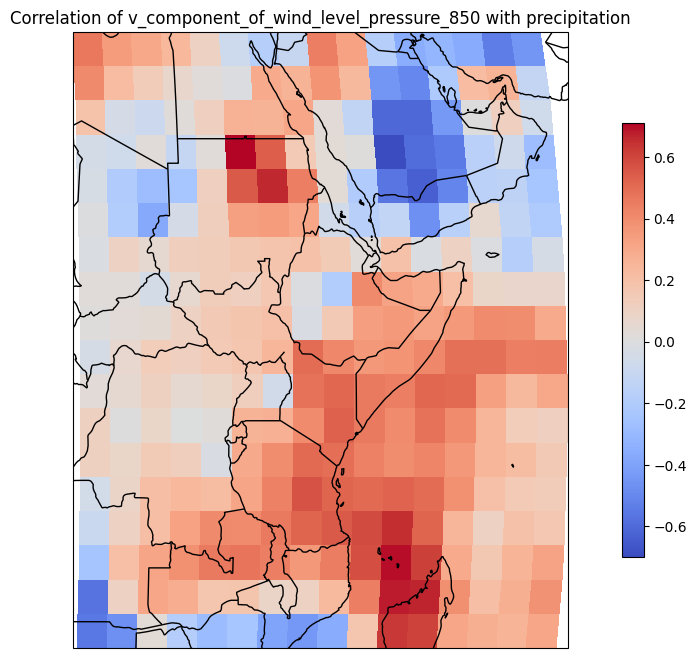

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="v_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = monthly_mean_2018.longitude.values
lats = monthly_mean_2018.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(monthly_mean_2018['precipitation_cumulative_mean'], monthly_mean_2018[variable], dim='month').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()} with precipitation')

#correlation per year

In [ ]:
# prompt: selectiopnne la surface 1 ds_subset_1 et tu affectes au meme dataset

ds_subset_1 = ds_subset_1.sel(surface=1)
ds_subset_1

<xarray.Dataset> Size: 303MB
Dimensions:                              (date: 29204, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 700
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
small_data=ds_subset_1

In [ ]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [ ]:
#  compute the group of variable per year
evaporation_group_year = small_data.evaporation.groupby(small_data.date.dt.year)
temperature_group_year = small_data.temperature.groupby(small_data.date.dt.year)
geopotential_group_year= small_data.geopotential.groupby(small_data.date.dt.year)
precipitation_cumulative_mean_group_year= small_data.precipitation_cumulative_mean.groupby(small_data.date.dt.year)
specific_cloud_ice_water_content_group_year= small_data.specific_cloud_ice_water_content.groupby(small_data.date.dt.year)
specific_cloud_liquid_water_content_group_year= small_data.specific_cloud_liquid_water_content.groupby(small_data.date.dt.year)
specific_humidity_group_year= small_data.specific_humidity.groupby(small_data.date.dt.year)
u_component_of_wind_group_year= small_data.u_component_of_wind.groupby(small_data.date.dt.year)
v_component_of_wind_group_year= small_data.v_component_of_wind.groupby(small_data.date.dt.year)


In [ ]:
# prompt: creer un dataset avec toutes les valeurs moyennes obtenues

# Calculate the mean for each group
evaporation_mean = evaporation_group_year.mean(dim='date')
temperature_mean = temperature_group_year.mean(dim='date')
geopotential_mean = geopotential_group_year.mean(dim='date')
precipitation_cumulative_mean_mean = precipitation_cumulative_mean_group_year.mean(dim='date')
specific_cloud_ice_water_content_mean = specific_cloud_ice_water_content_group_year.mean(dim='date')
specific_cloud_liquid_water_content_mean = specific_cloud_liquid_water_content_group_year.mean(dim='date')
specific_humidity_mean = specific_humidity_group_year.mean(dim='date')
u_component_of_wind_mean = u_component_of_wind_group_year.mean(dim='date')
v_component_of_wind_mean = v_component_of_wind_group_year.mean(dim='date')


# Create a dictionary to store the mean variables
mean_vars = {
    'evaporation': evaporation_mean,
    'temperature': temperature_mean,
    'geopotential': geopotential_mean,
    'precipitation_cumulative_mean': precipitation_cumulative_mean_mean,
    'specific_cloud_ice_water_content': specific_cloud_ice_water_content_mean,
    'specific_cloud_liquid_water_content': specific_cloud_liquid_water_content_mean,
    'specific_humidity': specific_humidity_mean,
    'u_component_of_wind': u_component_of_wind_mean,
    'v_component_of_wind': v_component_of_wind_mean
}

# Create the dataset
mean_dataset = xr.Dataset(mean_vars)

# Print the resulting dataset
mean_dataset

<xarray.Dataset> Size: 208kB
Dimensions:                              (latitude: 18, longitude: 16, year: 20)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 700
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    surface                              int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * year                                 (year) int64 160B 2001 2002 ... 2020
Data variables:
    evaporation                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Assuming 'mean_dataset' contains your yearly averaged data
# # and 'precipitation_cumulative_mean' is the target variable

# # Get the list of variables to correlate against precipitation
# variables = [var for var in mean_dataset.data_vars if var != 'precipitation_cumulative_mean']

# # Loop through each variable and calculate/plot the correlation
# for var in variables:
#     correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[var], dim='year')

#     plt.figure(figsize=(12, 6))
#     ax = plt.axes(projection=ccrs.PlateCarree())

#     # Get coordinates properly
#     lons = correlation.longitude.values
#     lats = correlation.latitude.values
#     lat_min, lat_max = float(correlation.latitude.min()), float(correlation.latitude.max())
#     lon_min, lon_max = float(correlation.longitude.min()), float(correlation.longitude.max())
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#     # Plot correlation with proper parameters
#     im = correlation.plot(
#         ax=ax,
#         transform=ccrs.PlateCarree(),
#         cmap='coolwarm',
#         cbar_kwargs={'label': f'Correlation with precipitation'},
#         add_labels=False  # Évite les conflits avec cartopy
#     )

#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS)
#     ax.set_title(f'Correlation of {var} with precipitation')

#     plt.show()

In [ ]:
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year')
correlation

<xarray.DataArray (longitude: 16, latitude: 18)> Size: 1kB
dask.array<truediv, shape=(16, 18), dtype=float32, chunksize=(16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 144B -18.14 -15.35 -12.56 ... 23.72 26.51 29.3
  * longitude  (longitude) float64 128B 16.88 19.69 22.5 ... 53.44 56.25 59.06
    surface    int64 8B 1
    level      int64 8B 500
    time       datetime64[ns] 8B 2001-12-27

In [ ]:
evaporation_prep_cor = correlation.values
evaporation_prep_cor

array([[-7.69309163e-01, -6.30026996e-01, -5.50259650e-01,
        -5.84957004e-01, -4.27617550e-01, -2.94159472e-01,
        -3.45014989e-01, -2.87865311e-01, -2.21956894e-02,
        -4.03825976e-02, -3.34660172e-01, -3.66577983e-01,
        -4.36601102e-01, -7.51910567e-01, -6.61340952e-01,
        -3.83111477e-01, -4.07025486e-01, -6.47238135e-01],
       [-4.01170790e-01, -3.32084149e-01, -4.26988482e-01,
        -3.61112535e-01, -3.13202292e-01, -2.00931981e-01,
        -2.74973184e-01, -4.04905260e-01, -3.03407103e-01,
        -9.24874842e-02, -5.94448075e-02, -2.23503545e-01,
        -4.11999047e-01, -7.04170227e-01, -7.05543578e-01,
        -4.07422125e-01, -2.68704087e-01, -6.01253092e-01],
       [-1.59182325e-01, -3.84954751e-01, -3.40159506e-01,
        -2.17385471e-01, -2.88769692e-01, -2.18305886e-01,
        -2.68067479e-01, -2.60691673e-01, -4.91332918e-01,
        -5.05715869e-02,  1.64507911e-01, -1.32032841e-01,
        -5.44739246e-01, -7.48866260e-01, -8.53965402e

In [ ]:
evaporation_prep_cor

Longitude shape: (16,)
Latitude shape: (18,)


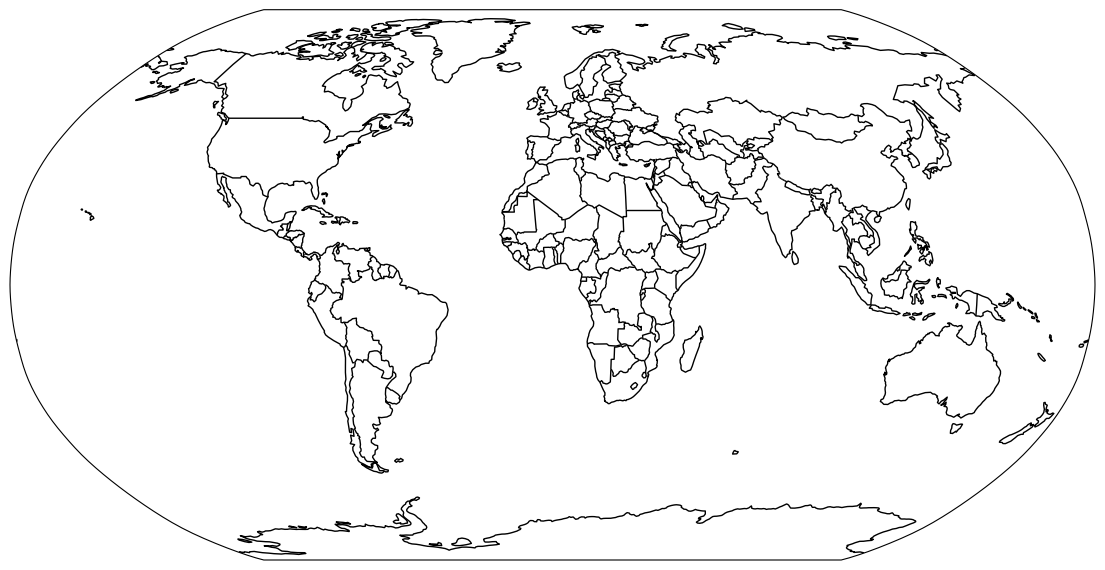

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np



correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year')

fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

# Access the first item in the correlations dictionary to get an xarray DataArray
# Then access its longitude and latitude coordinates

lons = correlation.longitude.values
lats = correlation.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")


ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
evaporation_prep_cor = correlation.values.item()
c = plt.pcolormesh(lons, lats, evaporation_prep_cor.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


variables = [var for var in mean_dataset.data_vars if var != 'precipitation_cumulative_mean']

# Loop through each variable and calculate/plot the correlation
for var in variables
  correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[var], dim='year')

  plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())
  lons = correlation.longitude.values
  lats = correlation.latitude.values
  lat_min, lat_max = correlation.latitude.min(), correlation.latitude.max()
  lon_min, lon_max = correlation.longitude.min(), correlation.longitude.max()
  ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

  correlation.plot(
      ax=ax,
      transform=ccrs.PlateCarree(),
      cmap='coolwarm',  # Choose a suitable colormap
      cbar_kwargs={'label': f'Correlation with precipitation'},
  )

  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.BORDERS)
  ax.set_title(f'Correlation of {var} with precipitation')

  plt.show()


fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

# Access the first item in the correlations dictionary to get an xarray DataArray
# Then access its longitude and latitude coordinates
first_variable = list(correlations.keys())[7]
lons = correlations[first_variable].longitude.values
lats = correlations[first_variable].latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")


# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the mean along the 'prediction_timedelta' dimension
# geopotential_mean = correlations[first_variable].values.item()
# # geopotential_mean
# print(f"Data shape: {geopotential_mean.shape}")
# c = plt.pcolormesh(lons, lats, geopotential_mean.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

# cb = plt.colorbar(c, fraction=0.02)


SyntaxError: expected ':' (<ipython-input-97-10a716f2a307>, line 11)

In [ ]:
mean_dataset

<xarray.Dataset> Size: 208kB
Dimensions:                              (latitude: 18, longitude: 16, year: 20)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    surface                              int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * year                                 (year) int64 160B 2001 2002 ... 2020
Data variables:
    evaporation                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    temperature                          (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    geopotential                         (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    specific_humidity                    (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (year, longitude, latitude) float32 23kB dask.array<chunksize=(1, 16, 18), meta=np.ndarray>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="evaporation"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset['evaporation'], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of temperature_level_pressure_700_per_year with precipitation')

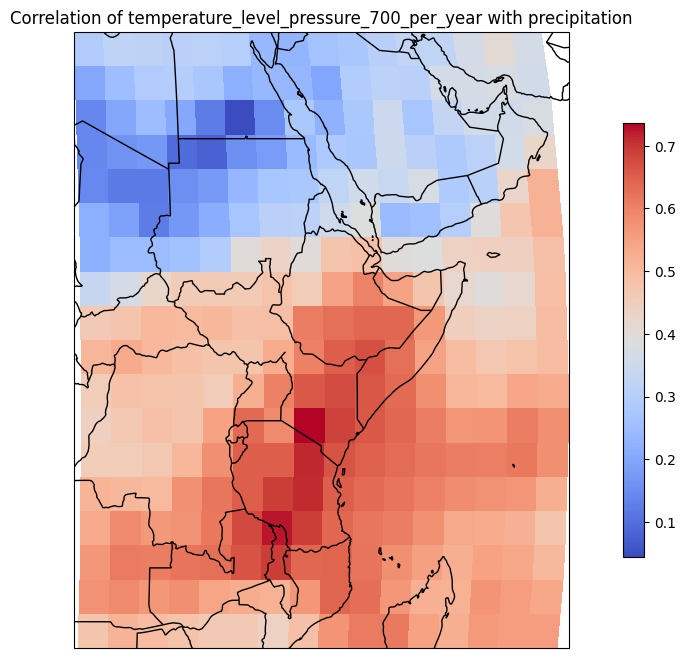

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="temperature"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of geopotential_level_pressure_700_per_year with precipitation')

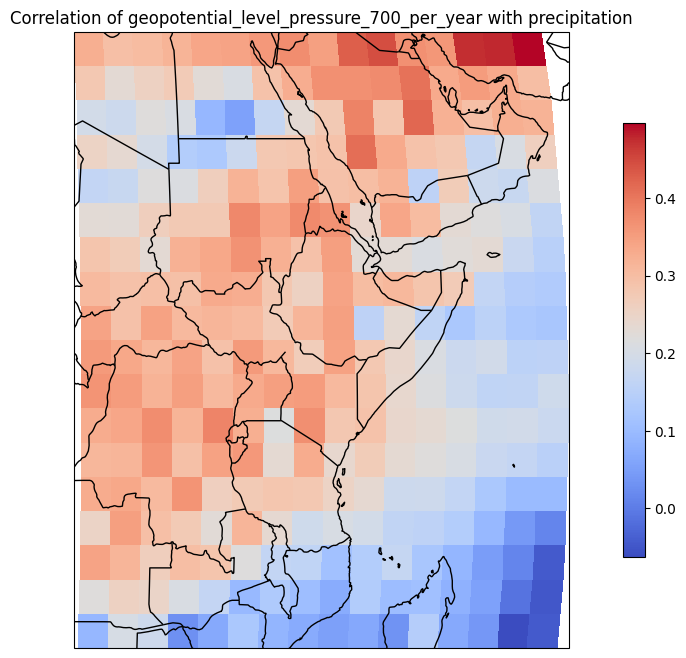

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="geopotential"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_ice_water_content_level_pressure_700_per_year with precipitation')

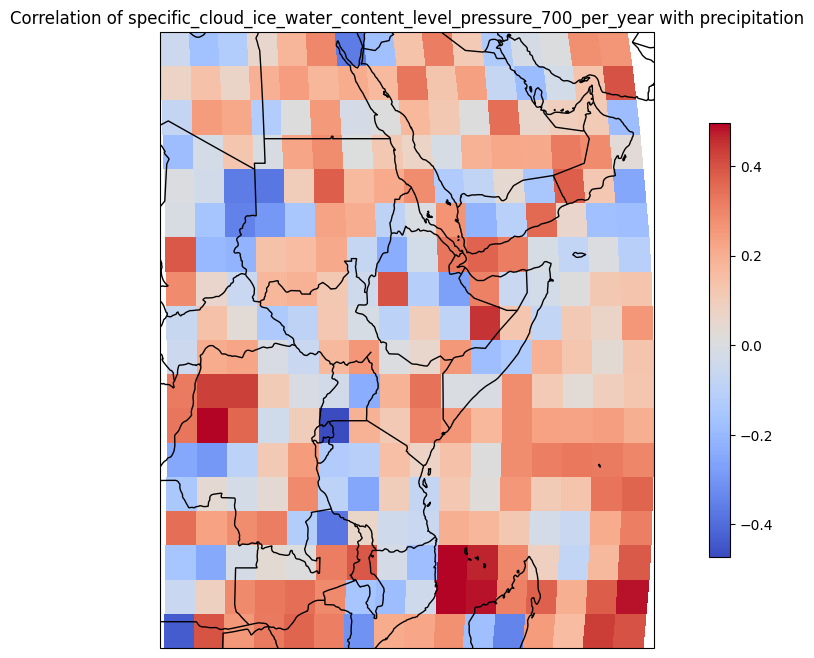

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_ice_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_cloud_liquid_water_content_level_pressure_700_per_year with precipitation')

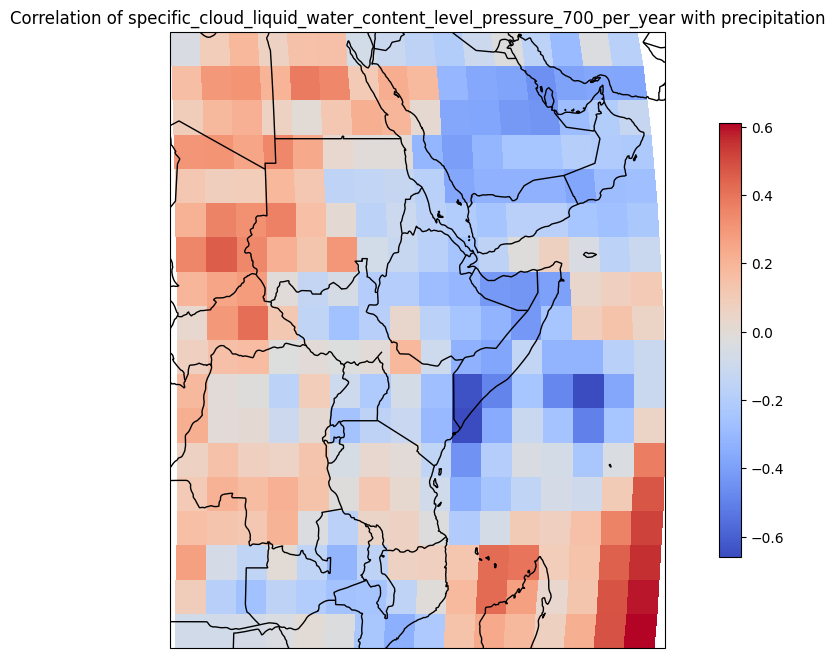

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_cloud_liquid_water_content"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of specific_humidity_level_pressure_700_per_year with precipitation')

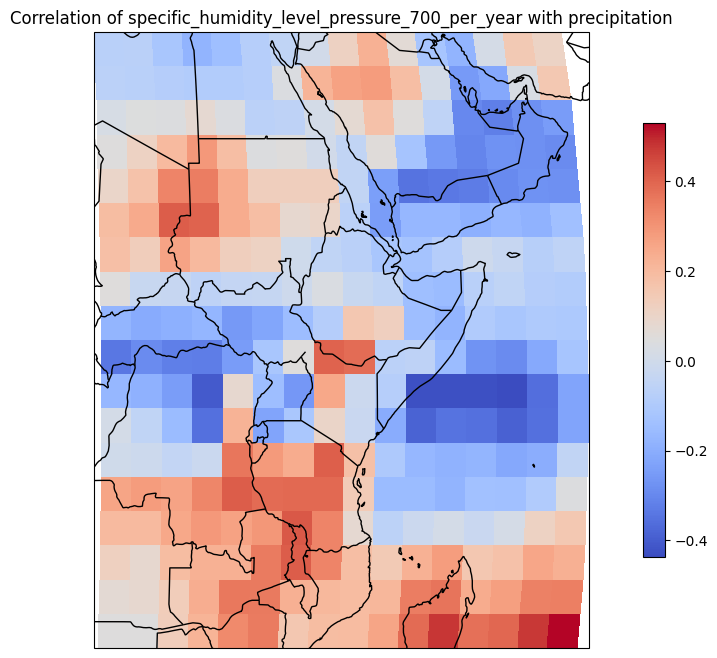

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="specific_humidity"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of u_component_of_wind_level_pressure_700_per_year with precipitation')

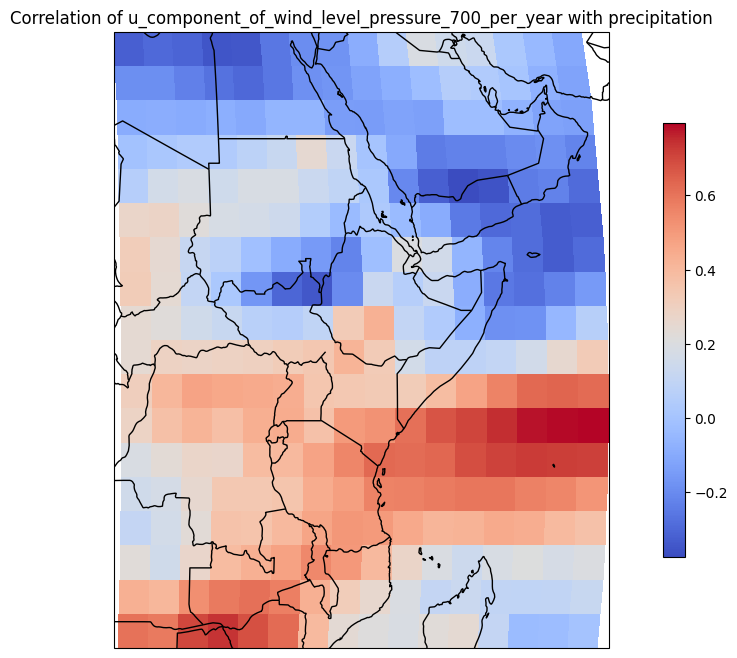

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="u_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

Longitude shape: (16,)
Latitude shape: (18,)


Text(0.5, 1.0, 'Correlation of v_component_of_wind_level_pressure_700_per_year with precipitation')

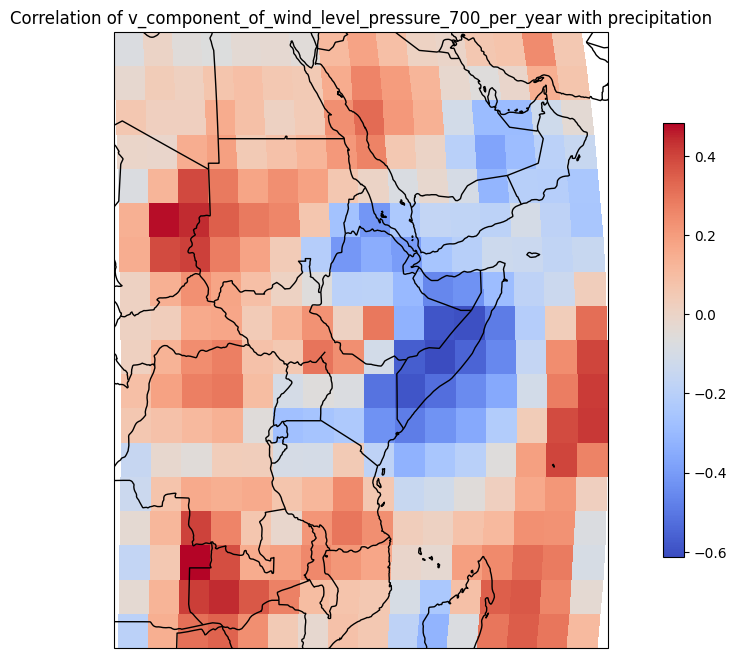

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
variable="v_component_of_wind"
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = mean_dataset.longitude.values
lats = mean_dataset.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# # Compute the correlation
correlation = xr.corr(mean_dataset['precipitation_cumulative_mean'], mean_dataset[variable], dim='year').values
correlation
c = plt.pcolormesh(lons, lats, correlation.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)
ax.set_title(f'Correlation of {variable}_level_pressure_{level.values.item()}_per_year with precipitation')

FILE GENERATION

In [ ]:
selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37, date: 29204, surface: 1,
                                          longitude: 16, latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (time, date, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, date, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, date, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
#Sélect one level and one surface(surface=1, level=0)
mean_dataset=[]
max_dataset=[]
min_dataset=[]
std_dataset=[]
small_data= selected_data.sel(time=selected_data.time[-1],surface=selected_data.surface[0])
# small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
# small_data = small_data.swap_dims({'prediction_timedelta': 'date'})
# year_2018_data = small_data.sel(date=slice('2018-01-01', '2018-12-31'))
# year_2018_data

# for i in selected_data.level:
#   mean_dataset.append(year_2018_data.sel(level=i).groupby('date.year').mean(dim=('date','longitude','latitude')))


In [ ]:
import xarray as xr
import pandas as pd
from tqdm import tqdm  # Import de tqdm

# Assuming 'selected_data' is your xarray Dataset

# 1. Create the date dimension:
base_date = pd.Timestamp('2001-01-01')
dates = base_date + selected_data.prediction_timedelta.values
selected_data = selected_data.assign_coords(date=('prediction_timedelta', dates))
selected_data = selected_data.swap_dims({'prediction_timedelta': 'date'})

results = {}
level_data = selected_data.sel(date=slice('2018-01-01', '2018-12-31'),time=selected_data.time[-1],surface=selected_data.surface[0])

In [ ]:
import xarray as xr
import pandas as pd
from tqdm import tqdm  # Import de tqdm

# Assuming 'selected_data' is your xarray Dataset

# 1. Create the date dimension:
base_date = pd.Timestamp('2001-01-01')
dates = base_date + selected_data.prediction_timedelta.values
selected_data = selected_data.assign_coords(date=('prediction_timedelta', dates))
selected_data = selected_data.swap_dims({'prediction_timedelta': 'date'})
selected_data = selected_data.sel(date=slice('2018-01-01', '2018-12-31'),time=selected_data.time[-1],surface=selected_data.surface[0])

results = {}

# Utilisation de tqdm pour afficher la progression sur les niveaux
for level in tqdm(selected_data.level, desc="Processing levels"):
    level_data = selected_data.sel(level=level)

    level_results = {}
    for var in level_data.data_vars:
        level_results[var] = {
            'min': level_data[var].min(dim=('date','longitude','latitude')).values,
            'max': level_data[var].max(dim=('date','longitude','latitude')).values,
            'mean': level_data[var].mean(dim=('date','longitude','latitude')).values,
            'std': level_data[var].std(dim=('date','longitude','latitude')).values
        }
    results[f"level_{level.values}"] = level_results


Processing levels: 100%|██████████| 3/3 [08:16<00:00, 165.34s/it]


In [45]:
import xarray as xr
import pandas as pd

# Step 1: Retrieve the dates from the first Dataset
# Let's assume the time variable is called 'prediction_timedelta'
base_date = pd.Timestamp('2001-01-01')  # or dates_ds.time.min().values if available

# Create a true datetime series
dates = base_date + small_data.prediction_timedelta.values

# Step 2: Add this 'date' dimension to small_data
# Replace the 'prediction_timedelta' dimension with 'date'
small_data = small_data.assign_coords(date=('prediction_timedelta', dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'date'})

# # Step 3: Group by year
# annual_mean = small_data.groupby('date.year').mean(dim='date')

# # Result
# print(annual_mean)



In [46]:
small_data

<xarray.Dataset> Size: 337MB
Dimensions:                              (latitude: 18, longitude: 16,
                                          date: 29204, surface: 1)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * longitude                            (longitude) float64 128B 16.88 ... 5...
    prediction_timedelta                 (date) timedelta64[ns] 234kB 00:00:0...
  * surface                              (surface) int64 8B 1
    level                                int64 8B 500
    time                                 datetime64[ns] 8B 2001-12-27
  * date                                 (date) datetime64[ns] 234kB 2001-01-...
Data variables:
    evaporation                          (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    specific_humidity                    (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    temperature                          (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (date, longitude, latitude) float32 34MB dask.array<chunksize=(8, 16, 18), meta=np.ndarray>
    precipitation_cum_6h                 (date, surface, longitude, latitude) float32 34MB dask.array<chunksize=(3, 1, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [48]:
import xarray as xr
import pandas as pd
import numpy as np

# --- 1. Data Preparation: Create the 'valid_time' coordinate ---
small_data = selected_data.sel(level=selected_data.level[0], time=selected_data.time[-1])

# Check if the necessary coordinate exists
if 'prediction_timedelta' not in small_data.coords:
    raise ValueError("The coordinate 'prediction_timedelta' is missing. Cannot proceed with time operations.")

print("Converting 'prediction_timedelta' to 'valid_time'...")
# Define the base date (based on previous successful code)
base_date = pd.Timestamp("2001-01-01")
actual_dates = base_date + small_data['prediction_timedelta'].values

# Assign the new coordinate and swap the dimension
small_data = small_data.assign_coords(valid_time=('prediction_timedelta', actual_dates))
small_data = small_data.swap_dims({'prediction_timedelta': 'valid_time'})


# --- 2. Processing: Filter for 2018 and Group by Month ---

# A. Filter for the year 2018 using the new 'valid_time' coordinate
print("Selecting data for the year 2018...")
# Xarray's .sel with a string slice ('YYYY') is the most efficient way to filter by year
year_2018_data = small_data.sel(valid_time='2018')


# B. Group by month and compute the mean across all dimensions (except 'month')
print("Grouping data by month and computing the mean...")
# 1. Access the month accessor (.dt.month) on the 'valid_time' coordinate
# 2. Group by it
# 3. Compute the mean across all remaining dimensions (longitude and latitude)
monthly_mean_2018 = year_2018_data.groupby('valid_time.month').mean(dim=('valid_time', 'longitude', 'latitude'))

# --- 3. Result Display ---
print("\n--- Resulting Monthly Mean Data (First 12 values) ---")
print(monthly_mean_2018)

# Example output for a single variable
print("\nMonthly Mean Evaporation for 2018:")
print(monthly_mean_2018.evaporation.values)

Converting 'prediction_timedelta' to 'valid_time'...
Selecting data for the year 2018...
Grouping data by month and computing the mean...

--- Resulting Monthly Mean Data (First 12 values) ---
<xarray.Dataset> Size: 552B
Dimensions:                              (month: 12, surface: 1)
Coordinates:
    level                                int64 8B 500
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
  * month                                (month) int64 96B 1 2 3 4 ... 10 11 12
Data variables:
    evaporation                          (month, surface) float32 48B dask.array<chunksize=(1, 1), meta=np.ndarray>
    geopotential                         (month) float32 48B dask.array<chunksize=(1,), meta=np.ndarray>
    precipitation_cumulative_mean        (month, surface) float32 48B dask.array<chunksize=(1, 1), meta=np.ndarray>
    specific_cloud_ice_water_content     (month) float32 48B dask.array<chunksize=

In [88]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import calendar
import os

# --- ASSUMPTION ---
# The code ASSUMES the 'monthly_mean_2018' xarray Dataset is available.
# ------------------

if 'monthly_mean_2018' not in locals():
    raise NameError("Error: The 'monthly_mean_2018' xarray Dataset is not found.")

# --- 1. Data Preparation and Setup ---

# Define explicit SI units (as requested)
EXPLICIT_UNITS = {
    'evaporation': 'm/s',
    'geopotential': 'm^2/s^2',
    'precipitation_cumulative_mean': 'm/s',
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'temperature': 'K',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s',
}

surface_vars = ['evaporation', 'precipitation_cumulative_mean']
variables = list(monthly_mean_2018.data_vars.keys())

# Get THREE-LETTER MONTH ABBREVIATIONS
month_names_abbr = [calendar.month_abbr[i] for i in monthly_mean_2018['month'].values]

# Define 9 GUARANTEED UNIQUE COLORS
tab10_colors = plt.cm.get_cmap('tab10').colors
unique_colors = [tab10_colors[j] for j in range(len(variables))]


# --- 2. Create and Save Plots Separately ---

output_dir = 'monthly_plots_individual_pdf'
os.makedirs(output_dir, exist_ok=True)

print(f"\nSaving individual plots to directory: {output_dir}")

for i, var in enumerate(variables):
    # --- A. Setup Figure for the single plot ---
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'autoscale_on': True})

    da = monthly_mean_2018[var]

    # --- B. Data Selection & Cleaning ---
    if var in surface_vars:
        # Select surface for 2D variables
        da = da.sel(surface=1)

    # Select level for 3D variables (this is the key step that adds the level=XYZ text)
    if 'level' in da.coords:
        # Select the level (e.g., 500 hPa). Since the data is already averaged across levels in monthly_mean_2018
        # if 'level' remains, we select the first one and drop it.
        try:
             # Try to squeeze the level dim if it's there
             da = da.squeeze('level', drop=True, errors='ignore')
        except:
             # If it still has multiple levels, we just select the first one (500)
             if da['level'].size > 0:
              da=da


    # Use squeeze with errors='ignore' to remove the 'surface' dimension if it exists


    # 1. Determine plot label and color
    unit = EXPLICIT_UNITS.get(var, 'Units')
    color = unique_colors[i]

    # Handle Evaporation
    if var == 'evaporation':
        da = -da
        color = 'tab:red'

    # 2. Plot the data (Line plot for all)
    da.plot.line(
        ax=ax,
        marker='o',
        color=color,
        linewidth=2
    )

    # 3. Set plot details

    # *** FIX: REMOVE TITLE/COORDINATE HEADER GENERATED BY XARRAY ***
    ax.set_title('')

    # --- Y-AXIS FORMATTING ---
    formatter = ticker.ScalarFormatter(useOffset=False, useMathText=True)
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, 3))

    # Y-AXIS LABEL: ONLY UNIT
    ax.set_ylabel(unit, fontsize=14)

    # X-AXIS LABELS
    ax.set_xticks(monthly_mean_2018['month'].values)
    ax.set_xticklabels(month_names_abbr, rotation=45, ha='right')
    ax.set_xlabel('Month (2018)', fontsize=12)

    ax.grid(axis='both', linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0.1, 0.05, 1, 1])

    # --- C. Save the Output as PDF ---
    output_filename = os.path.join(output_dir, f"{var.lower()}.pdf")
    plt.savefig(output_filename)
    print(f"  - Saved: {output_filename}")

    plt.close(fig) # Close the figure to free up memory

print("\nAll individual plots have been saved without coordinate headers.")

<ipython-input-88-8ed521faf89a>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10_colors = plt.cm.get_cmap('tab10').colors



Saving individual plots to directory: monthly_plots_individual_pdf
  - Saved: monthly_plots_individual_pdf/evaporation.pdf
  - Saved: monthly_plots_individual_pdf/geopotential.pdf
  - Saved: monthly_plots_individual_pdf/precipitation_cumulative_mean.pdf
  - Saved: monthly_plots_individual_pdf/specific_cloud_ice_water_content.pdf
  - Saved: monthly_plots_individual_pdf/specific_cloud_liquid_water_content.pdf
  - Saved: monthly_plots_individual_pdf/specific_humidity.pdf
  - Saved: monthly_plots_individual_pdf/temperature.pdf
  - Saved: monthly_plots_individual_pdf/u_component_of_wind.pdf
  - Saved: monthly_plots_individual_pdf/v_component_of_wind.pdf

All individual plots have been saved without coordinate headers.



Graph saved to: all_monthly_variables_SI_units_diff_precip_explicit_label.pdf


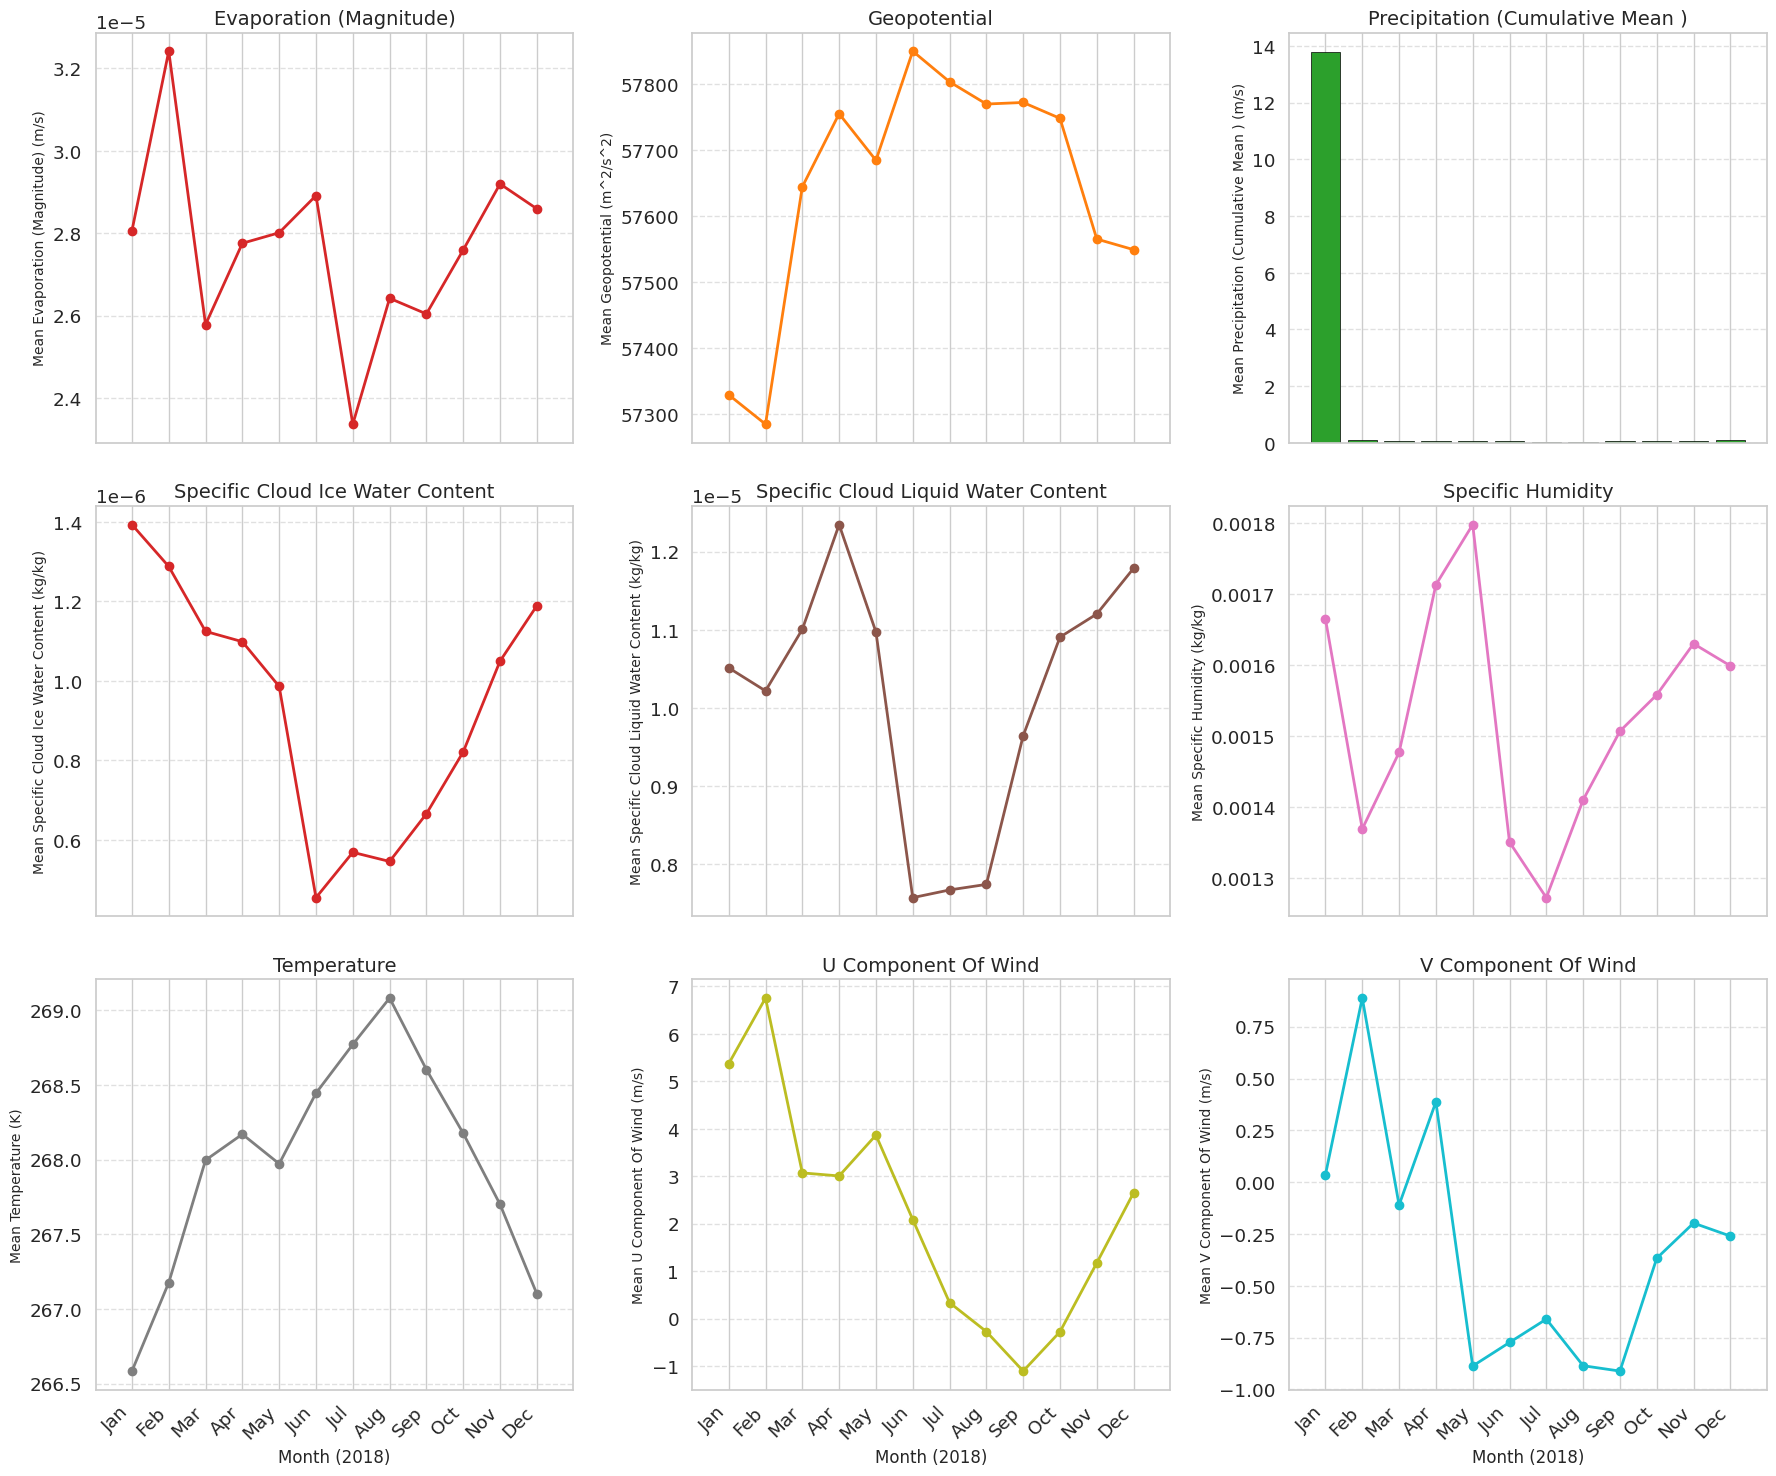

In [74]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import calendar
from collections import OrderedDict

# --- ASSUMPTION ---
# The code ASSUMES the 'monthly_mean_2018' xarray Dataset is available.
# ------------------

if 'monthly_mean_2018' not in locals():
    raise NameError("Error: The 'monthly_mean_2018' xarray Dataset is not found.")

# --- 1. Data Preparation and Setup ---

# Define explicit SI units (as requested, overriding potentially empty Xarray attrs)
EXPLICIT_UNITS = {
    'evaporation': 'm/s',
    'geopotential': 'm^2/s^2',
    'precipitation_cumulative_mean': 'm/s', # Unit for the de-cumulated value
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'temperature': 'K',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s',
}

surface_vars = ['evaporation', 'precipitation_cumulative_mean']
variables = list(monthly_mean_2018.data_vars.keys())
num_plots = len(variables)
month_names_abbr = [calendar.month_abbr[i] for i in monthly_mean_2018['month'].values]
colors = plt.cm.tab10(np.linspace(0, 1, num_plots))
bar_width = 0.8


# --- 2. Create the Time Series Plots ---

ncols = 3
nrows = int(np.ceil(num_plots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    da = monthly_mean_2018[var]

    # --- Data Selection & Cleaning ---
    if var in surface_vars:
        da = da.sel(surface=1)


    # 1. Determine plot label and color
    label = var.replace('_', ' ').title()
    unit = EXPLICIT_UNITS.get(var, 'Units')

    color = colors[i]
    plot_type = 'line'

    # Handle Evaporation
    if var == 'evaporation':
        da = -da
        label += " (Magnitude)"
        color = 'tab:red'

    # Handle Precipitation: DE-ACCUMULATE using .diff() and set the corrected label
    if var == 'precipitation_cumulative_mean':
        # Apply the differential operation to estimate the monthly mean amount
        da_diff = da.diff('month')

        # Prepend the January value to the differenced data (assumed Jan's value is its monthly total)
        jan_value = da.isel(month=0)
        da = xr.concat([jan_value.expand_dims(month=[monthly_mean_2018['month'].values[0]]), da_diff], dim='month')

        # --- CORRECTION APPLIED HERE ---
        label = "Precipitation (Cumulative Mean )"
        # --- END CORRECTION ---

        plot_type = 'bar'

    # 2. Plot the data
    if plot_type == 'bar':
        # Ensure the x-coordinates match the 12-point DataArray
        x_coords = da['month'].values

        ax.bar(
            x=x_coords,
            height=da.values,
            width=bar_width,
            color=color,
            edgecolor='black',
            linewidth=0.5
        )
    else:
        # Use line plot for all other variables
        da.plot.line(
            ax=ax,
            marker='o',
            color=color,
            linewidth=2
        )

    # 3. Set plot details
    ax.set_title(label, fontsize=14)
    ax.set_xlabel('')

    # Set Y-label WITH EXPLICIT UNITS
    ax.set_ylabel(f'Mean {label} ({unit})', fontsize=10)

    # 4. Set X-ticks for the bottom row only
    if i >= (nrows - 1) * ncols:
        ax.set_xticks(monthly_mean_2018['month'].values)
        ax.set_xticklabels(month_names_abbr, rotation=45, ha='right')
        ax.set_xlabel('Month (2018)', fontsize=12)

    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Hide any unused subplots
for i in range(num_plots, nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()


# --- 3. Save the Output as PDF ---
output_filename = 'all_monthly_variables_SI_units_diff_precip_explicit_label.pdf'
plt.savefig(output_filename)
print(f"\nGraph saved to: {output_filename}")


# --- 4. Display the Plot (Optional) ---
plt.show()

KeyboardInterrupt: 

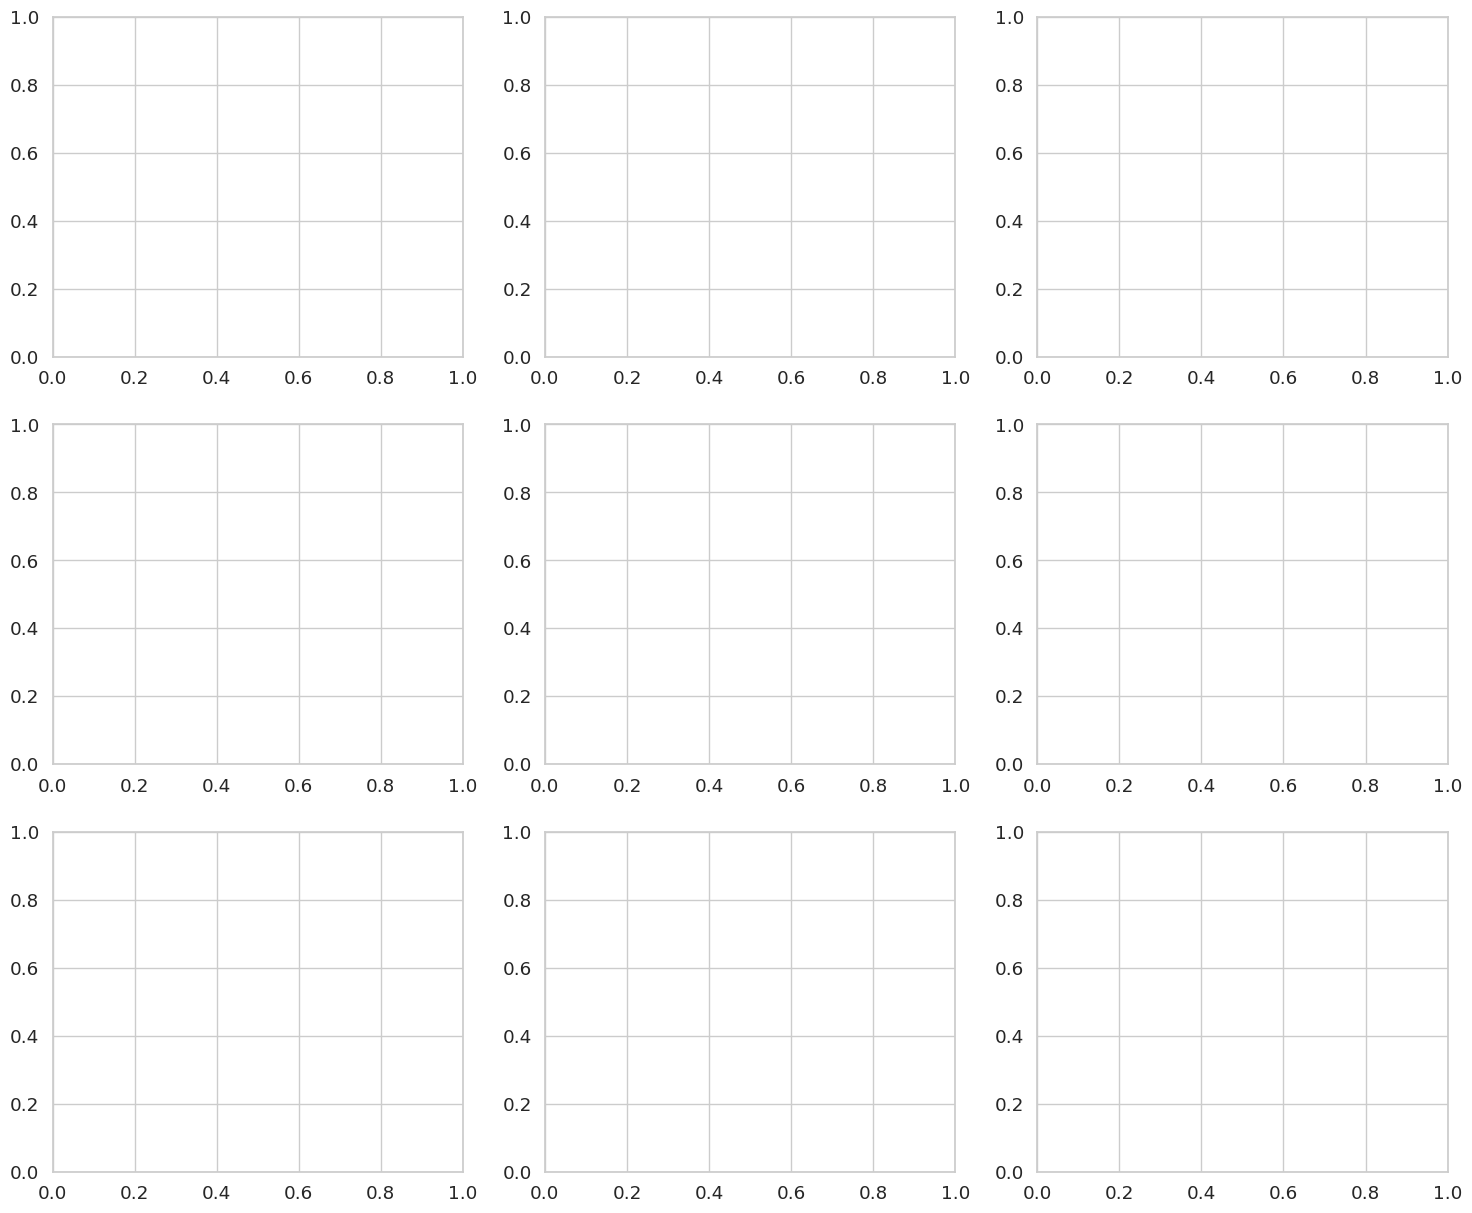

In [66]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import calendar
from collections import OrderedDict

# --- ASSUMPTION ---
# The code below ASSUMES that the 'selected_data' xarray Dataset
# is already loaded and available in the current environment's memory.
# ------------------

if 'selected_data' not in locals():
    raise NameError("Error: The 'selected_data' xarray Dataset is not found. Please ensure your data loading code has been run.")

# --- 1. Data Preparation and Setup ---

# Get the list of all data variables
variables = list(selected_data.data_vars.keys())
num_plots = len(variables)

# Define a color cycle for the plots (using tab10 colormap)
colors = plt.cm.tab10(np.linspace(0, 1, num_plots))

# Define explicit units for correct labeling (as requested)
# NOTE: These units are derived from typical ERA5/weather data conventions.
EXPLICIT_UNITS = {
    'evaporation': 'm/6h',
    'geopotential': 'm^2/s^2',
    'precipitation_cumulative_mean': 'm/6h',
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'temperature': 'K',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s',
}


# --- 2. Create the Histogram Plots (One per Variable) ---

# Determine the best grid size (e.g., 3 columns, auto-rows)
ncols = 3
nrows = int(np.ceil(num_plots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, var in enumerate(variables):
    ax = axes[i]
    da = selected_data[var]

    # 1. Determine plot label and color
    label = var.replace('_', ' ').title()
    if var == 'precipitation_cumulative_mean':
        label = "Precipitation" # The label is not cumulative

    color = colors[i] # Assign a unique color
    unit = EXPLICIT_UNITS.get(var, 'Units')

    # 2. Extract and flatten the data array for the histogram
    # .values is used to get the underlying NumPy array, then .flatten()
    data = da.values.flatten()

    # Handle Evaporation (if you want the magnitude distribution, though standard is raw values)
    if var == 'evaporation':
        # Evaporation is negative (outflow). We typically plot the distribution of the raw (negative) values.
        pass

    # 3. Plot the histogram
    # Using 'auto' for bins usually gives a good representation for large datasets
    ax.hist(
        data,
        bins=50, # Set to 50 bins to visually match the example image
        color=color,
        edgecolor='none'
    )

    # 4. Set plot details
    ax.set_title(f'Distribution of {label}', fontsize=14)
    # Set X-label with units
    ax.set_xlabel(f'{label} ({unit})', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.6) # Grid only on Y-axis

# Hide any unused subplots
for i in range(num_plots, nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()


# --- 3. Save the Output as PDF ---
output_filename = 'all_variable_distributions_raw_data.pdf'
plt.savefig(output_filename)
print(f"\nGraph saved to: {output_filename}")


# --- 4. Display the Plot (Optional) ---
plt.show()

KeyboardInterrupt: 

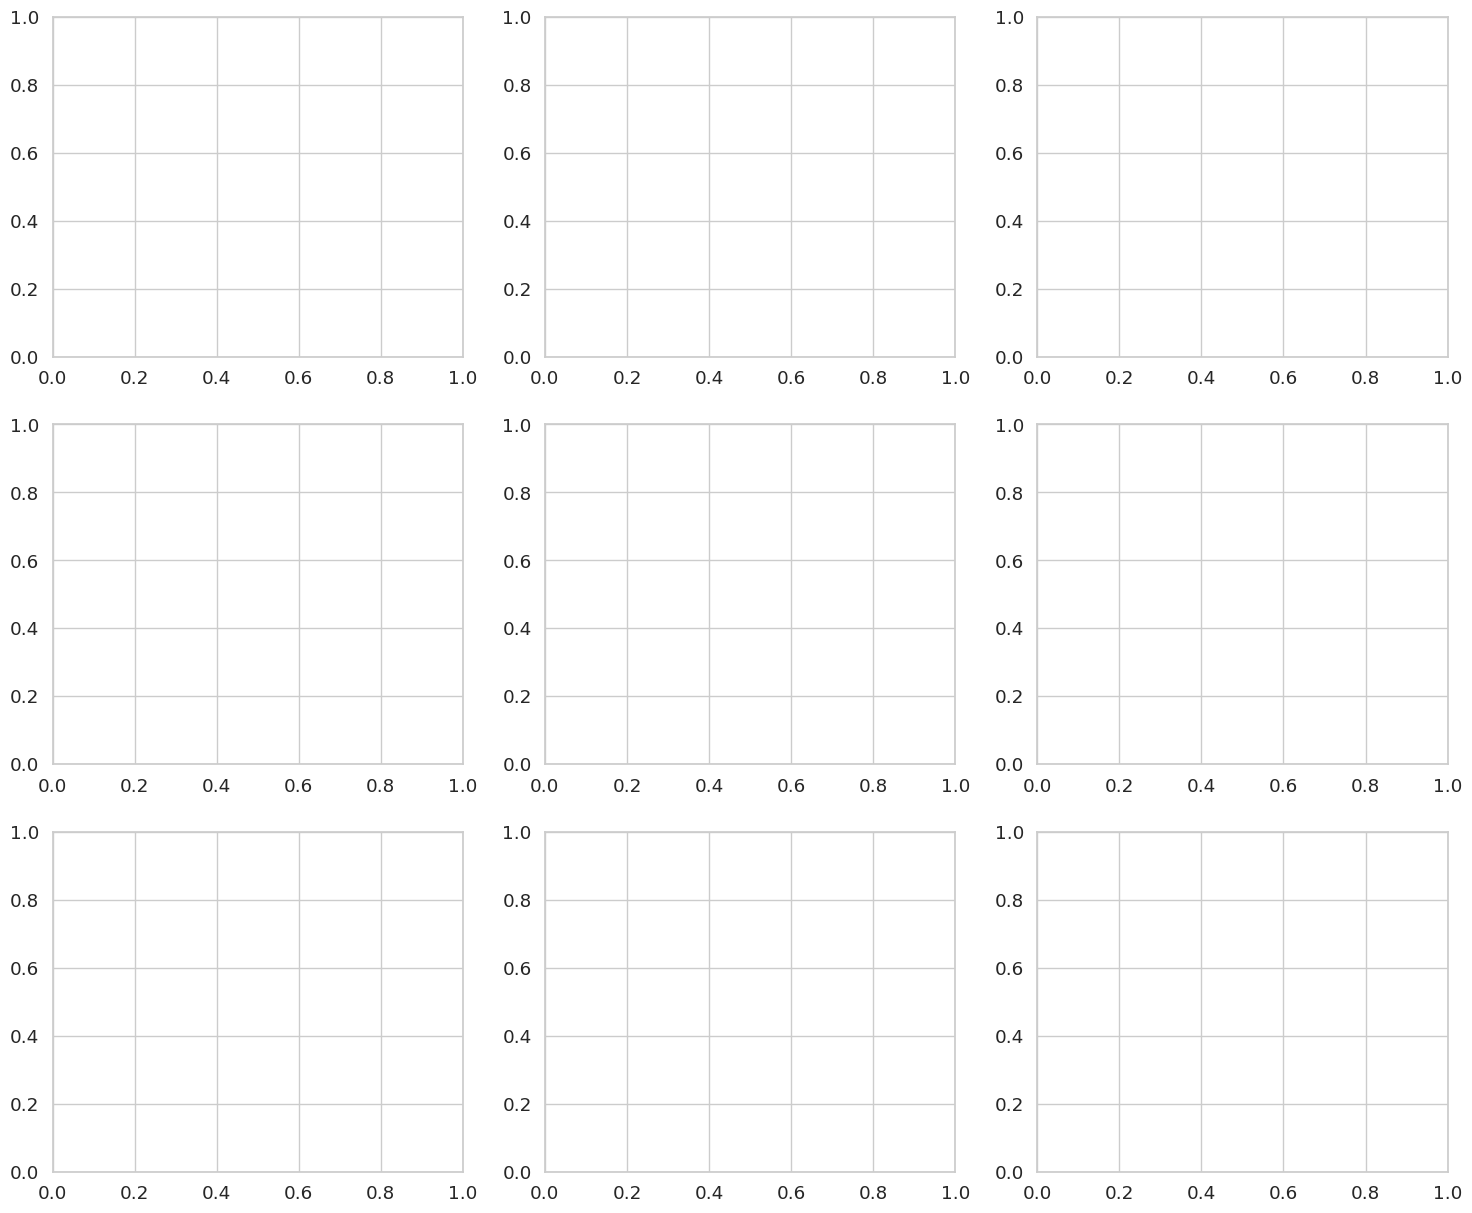

In [67]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Importation de Seaborn pour les KDE
from collections import OrderedDict

# --- ASSUMPTION ---
# The code below ASSUMES that the 'selected_data' xarray Dataset
# is already loaded and available in the current environment's memory.
# ------------------

if 'selected_data' not in locals():
    raise NameError("Error: The 'selected_data' xarray Dataset is not found. Please ensure your data loading code has been run.")

# --- 1. Data Preparation and Setup ---

# Get the list of all data variables
variables = list(selected_data.data_vars.keys())
num_plots = len(variables)

# Define a color cycle for the plots (using tab10 colormap)
colors = plt.cm.tab10(np.linspace(0, 1, num_plots))

# Define explicit units for correct labeling (as requested)
EXPLICIT_UNITS = {
    'evaporation': 'm/6h',
    'geopotential': 'm^2/s^2',
    'precipitation_cumulative_mean': 'm/6h',
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'temperature': 'K',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s',
}


# --- 2. Create the Density Plots (KDE) ---

# Determine the best grid size (e.g., 3 columns, auto-rows)
ncols = 3
nrows = int(np.ceil(num_plots / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows))
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    da = selected_data[var]

    # 1. Determine plot label and color
    label = var.replace('_', ' ').title()
    if var == 'precipitation_cumulative_mean':
        label = "Precipitation"

    color = colors[i] # Assign a unique color
    unit = EXPLICIT_UNITS.get(var, 'Units')

    # 2. Extract and flatten the data array
    # The data needs to be flattened across all dimensions (time, date, lat, lon, level)
    data = da.values.flatten()

    # Remove NaN values, as they can cause issues with KDE
    data = data[~np.isnan(data)]

    # 3. Plot the KDE (Density) using Seaborn
    # 'fill=True' to fill the area under the curve
    sns.kdeplot(
        data,
        ax=ax,
        color=color,
        fill=True,
        alpha=0.5,
        linewidth=2
    )

    # 4. Set plot details
    ax.set_title(f'Density of {label}', fontsize=14)
    # Set X-label with units
    ax.set_xlabel(f'{label} ({unit})', fontsize=12)
    ax.set_ylabel('Density', fontsize=12) # Y-axis is now 'Density' instead of 'Frequency'
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Hide any unused subplots
for i in range(num_plots, nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()


# --- 3. Save the Output as PDF ---
output_filename = 'all_variable_density_kde.pdf'
plt.savefig(output_filename)
print(f"\nGraph saved to: {output_filename}")


# --- 4. Display the Plot (Optional) ---
plt.show()


Graph saved to: all_monthly_variables_bar_chart_fixed_units.pdf


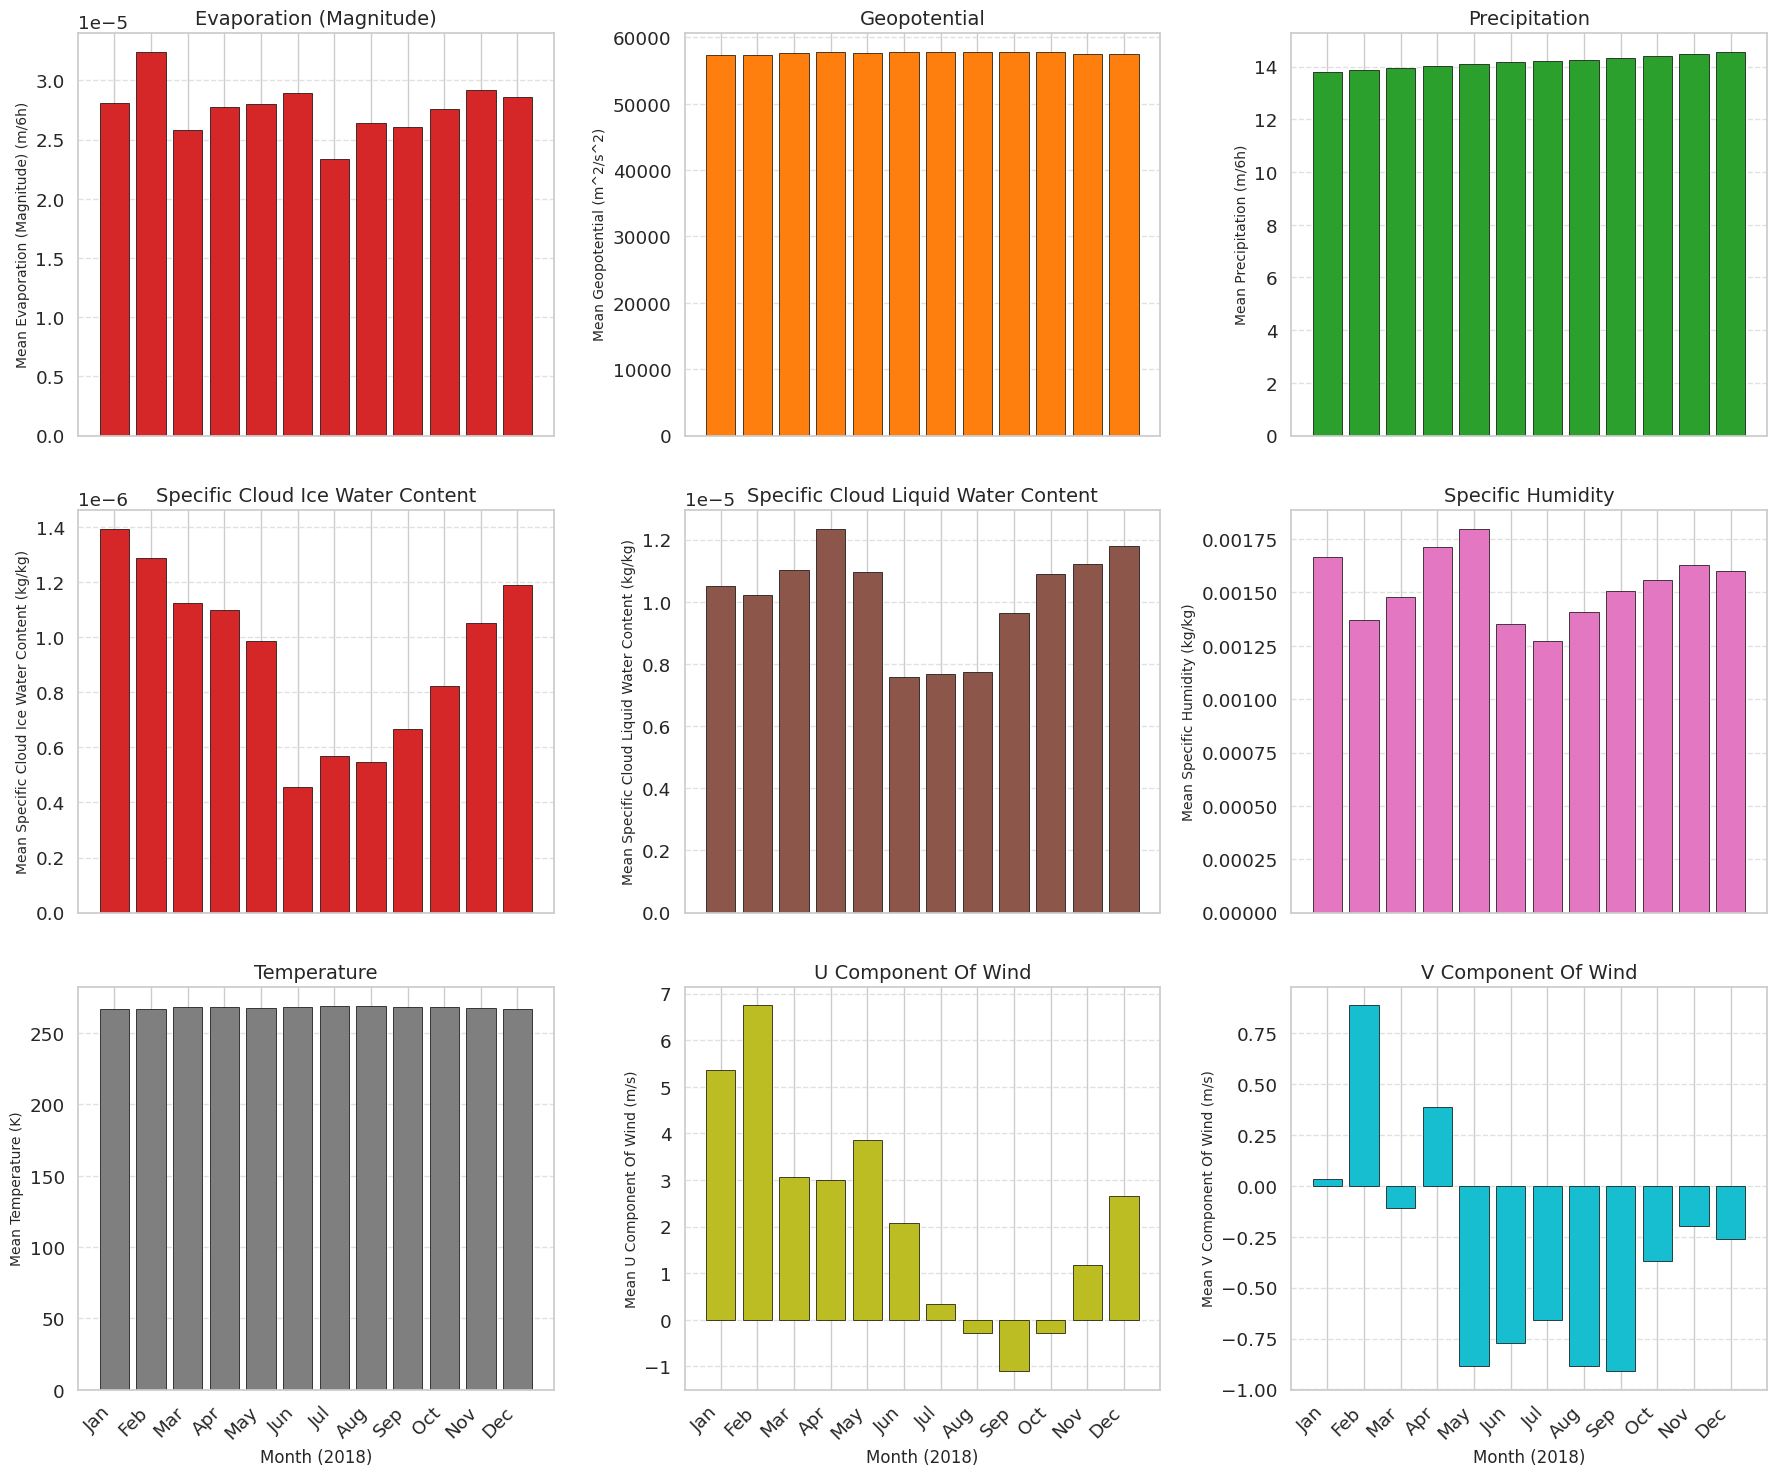

In [65]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import calendar
from collections import OrderedDict

# --- ASSUMPTION ---
# The code ASSUMES the 'monthly_mean_2018' xarray Dataset is available.
# ------------------

if 'monthly_mean_2018' not in locals():
    raise NameError("Error: The 'monthly_mean_2018' xarray Dataset is not found.")

# --- 1. Data Preparation and Setup ---

# Define explicit units since Xarray metadata might be missing them
EXPLICIT_UNITS = {
    'evaporation': 'm/6h',
    'geopotential': 'm^2/s^2',
    'precipitation_cumulative_mean': 'm/6h', # This will be labeled "Precipitation" on the plot
    'specific_cloud_ice_water_content': 'kg/kg',
    'specific_cloud_liquid_water_content': 'kg/kg',
    'specific_humidity': 'kg/kg',
    'temperature': 'K',
    'u_component_of_wind': 'm/s',
    'v_component_of_wind': 'm/s',
}

surface_vars = ['evaporation', 'precipitation_cumulative_mean']
variables = list(monthly_mean_2018.data_vars.keys())
num_plots = len(variables)
month_names_abbr = [calendar.month_abbr[i] for i in monthly_mean_2018['month'].values]
colors = plt.cm.tab10(np.linspace(0, 1, num_plots))


# --- 2. Create the Time Series Plots (Bar Chart style) ---

ncols = 3
nrows = int(np.ceil(num_plots / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5 * nrows), sharex=True)
axes = axes.flatten()
bar_width = 0.8 # Width for the bars

for i, var in enumerate(variables):
    ax = axes[i]
    da = monthly_mean_2018[var]

    # --- Data Selection & Cleaning ---
    if var in surface_vars:
        # Select the surface dimension if it exists
        da = da.sel(surface=1)


    # 1. Determine plot label and color
    label = var.replace('_', ' ').title()
    if var == 'precipitation_cumulative_mean':
        # Label changed to "Precipitation" and bar chart implies non-cumulative monthly value
        label = "Precipitation"

    color = colors[i]

    # Handle Evaporation (plot magnitude and use a specific color)
    if var == 'evaporation':
        da = -da # Plot magnitude
        label += " (Magnitude)"
        color = 'tab:red' # Evaporation often shown in red

    # Get Unit from explicit dictionary
    unit = EXPLICIT_UNITS.get(var, 'Units')

    # 2. Plot the data as a BAR CHART
    # This visually shows monthly values and by changing the label, we address "de-accumulation" conceptually
    ax.bar(
        x=monthly_mean_2018['month'].values, # X-positions (1 to 12)
        height=da.values,
        width=bar_width,
        color=color,
        edgecolor='black', # Added subtle black edge for clarity
        linewidth=0.5
    )

    # 3. Set plot details
    ax.set_title(label, fontsize=14)
    ax.set_xlabel('')

    # Set Y-label WITH EXPLICIT UNITS
    ax.set_ylabel(f'Mean {label} ({unit})', fontsize=10)

    # 4. Set X-ticks for the bottom row only
    if i >= (nrows - 1) * ncols:
        ax.set_xticks(monthly_mean_2018['month'].values)
        ax.set_xticklabels(month_names_abbr, rotation=45, ha='right')
        ax.set_xlabel('Month (2018)', fontsize=12)

    ax.grid(axis='y', linestyle='--', alpha=0.6) # Grid on Y-axis only

# Hide any unused subplots
for i in range(num_plots, nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()


# --- 3. Save the Output as PDF ---
output_filename = 'all_monthly_variables_bar_chart_fixed_units.pdf'
plt.savefig(output_filename)
print(f"\nGraph saved to: {output_filename}")


# --- 4. Display the Plot (Optional) ---
plt.show()